# Homework 1
- ## Advection equation ---> Gaussian as initial condition, applying
    - FCTS
    - Lax Friedrichs
    - Leapfrog
    - Lax Wendroff

    cf = 0,5, J = 101 (and change them)
    periodic boundary conditions, try laso outflow boundary conditions

- ## Advection equation ---> with step function as initil condition, applying:
    - lax Friedrichs 
    - Lax Wendroff

    cf = 0.5 , J = 101 and change them
    
- ## Burgers equation ---> gaussian
    - unwid, flux conservative
    - non flux conservative upwind
    
    cf =0.5, J = 101
    periodic boundary conditions 


----------
-----------

## ***ADVECTION EQUATION***
- WITH GAUSSIAN AS INITIAL CONDITION
- with step function as initial condition

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# a : speed
# L = Domain length
# n = Number of grid points ----> aumentandolo si alza... diminuendo quindi dx
# dx : Grid spacing



# BOUNDARY CONDITIONS: 
# Compute the new solution using the FTCS method
    # Note: np.roll(u_current, -1) is equivalent to u(j+1) and
    #       np.roll(u_current,  1) is equivalent to u(j-1)
    # using np.roll is equivalent to use periodic boundary conditions

In [52]:
def FTCS(u_current, a, dt, dx, boundary_condition='periodic'):
    if boundary_condition == 'periodic':
        u_next = u_current - a*dt/(2*dx)*(np.roll(u_current, -1) - np.roll(u_current, 1))
    return u_next  

def LAX_FRIEDRICHS(u_current, a, dt, dx):
    u_next = 1/2 * (np.roll(u_current, 1) + np.roll(u_current, -1)) - a*dt/(2*dx)*(np.roll(u_current, -1) - np.roll(u_current, 1))
    return u_next

def LAX_WENDROFF(u_current, a, dt, dx):
    u_next = u_current - a*dt/(2*dx)*(np.roll(u_current, -1) - np.roll(u_current, 1))+ a**2*dt**2/(2*dx**2)*(np.roll(u_current, -1) - 2 *u_current + np.roll(u_current, 1))
    return u_next

def LEAPFROG(u_current, u_previous, a, dt, dx, first_step=False):
    if first_step == True:
        u_next = 1/2 * (np.roll(u_current, 1) + np.roll(u_current, -1)) - a*dt/(2*dx)*(np.roll(u_current, -1) - np.roll(u_current, 1))
    else:
        u_next = (u_previous) - a*dt/(dx)*(np.roll(u_current, -1) - np.roll(u_current, 1))
    return u_next

def L2_norm(u_current):
    return np.sqrt(np.sum(u_current**2)/len(u_current))
     

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

colors = sns.color_palette("Set2")

def advection_equation(L=10.0, nx=101, cf=0.5, a=1.0, t_final=20, x0=5, u_initial='gaussian', method='FTCS', plots=True, movie=False, compare_with_saved_data=False):

    dx = L / (nx - 1)
    x = np.linspace(0, L, nx)
    dt = cf * dx / a 
    n_steps = int(t_final / dt)

    if u_initial == 'gaussian':
        u = np.exp(-((x - x0) ** 2))
    elif u_initial == 'step': 
        u = np.zeros_like(x)
        u[(x >= 4) & (x <= 6)] = 1.0  
    else:
        raise ValueError("Use 'gaussian' or 'step'.")

    u_current = u.copy()
    l2norm = [L2_norm(u_current)]
    time = [0.0]

    # For the dual evolution plot, we'll take 5 snapshots
    snapshot_data = []  
    snapshot_indices = set(np.linspace(0, n_steps, 5, dtype=int).tolist())
    snapshot_indices.add(n_steps)  

    if movie:
        folder_name = "frames/movie/advection/" + method 
        os.makedirs(folder_name, exist_ok=True)

    t = 0.0
    
    if method == 'LEAPFROG':
        if u_initial == 'gaussian':
            u_previous = np.exp(-((x + a*dt) - x0)**2)
        elif u_initial == 'step':
            u_previous = np.zeros_like(x)
            x_shifted = x + a*dt
            u_previous[(x_shifted >= 4) & (x_shifted <= 6)] = 1.0
        else:
            u_previous = u_current.copy()  

    for i in range(n_steps + 1):

        if i in snapshot_indices and plots:
            snapshot_data.append((t, u_current.copy(), l2norm.copy(), time.copy()))

        if movie:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=False)

            ax1.plot(x, u_current, color=colors[0])
            ax1.set_ylabel('u')
            ax1.set_xlabel('x')
            ax1.set_title(f'u(x) at t={t:.2f}')
            ax1.grid()

            ax2.plot(time, l2norm, color=colors[2])
            ax2.set_xlabel('Time')
            ax2.set_ylabel('L2 norm')
            ax2.set_title('L2 Norm Evolution')
            ax2.set_yscale('log')
            ax2.grid()

            plt.tight_layout()
            plt.savefig(folder_name + f"/frame_{i:04d}.png")
            plt.close()

        if i < n_steps:
            if method == 'FTCS':
                u_next = FTCS(u_current, a, dt, dx)
            elif method == 'LAX-FRIEDRICHS':
                u_next = LAX_FRIEDRICHS(u_current, a, dt, dx)
            elif method == 'LAX-WENDROFF':
                u_next = LAX_WENDROFF(u_current, a, dt, dx)
            elif method == 'LEAPFROG':
                u_next = LEAPFROG(u_current, u_previous, a, dt, dx, first_step=False)
                u_previous = u_current.copy()
            else:
                raise ValueError(" Use 'FTCS', 'LAX-FRIEDRICHS', 'LAX-WENDROFF', or 'LEAPFROG'.")

            u_current = u_next.copy()
            t += dt
            time.append(t)
            l2norm.append(L2_norm(u_current))
    if plots:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].plot(x, u, label='initial', color=colors[2], alpha=1, linewidth=2)
        axes[0].plot(x, u_current, label='final', color=colors[0], alpha=0.8, linewidth=2)
        axes[0].set_title(f'initial vs final time= {t:.2f}, method={method}')
        axes[0].set_ylim(-0.3, 1.3)
        axes[0].set_xlabel('x')
        axes[0].set_ylabel('u')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        l2norm_plot = l2norm
        ylabel = 'L2 norm'
        title = 'L2 norm evolution'
        
        axes[1].plot(time, l2norm_plot, color=colors[2], linewidth=2, label='computed')
        
        # IF I WANT TO COMPARE WITH SAVED DATA
        if compare_with_saved_data:

            l2_files = {
                'FTCS': './l2norm_FTCS.dat',
                'LAX-FRIEDRICHS': './l2norm_LAX.dat',
                'LAX-WENDROFF': './l2norm_LAXWENDROFF.dat',
                'LEAPFROG': './l2norm_LEAPFROG.dat'
            }
            
            if method in l2_files:
                l2_saved = np.genfromtxt(l2_files[method], comments='#')
                l2_ref_plot = l2_saved[:,1]
                
                axes[1].plot(l2_saved[:,0], l2_ref_plot, 'x', color=colors[1], 
                            markersize=5, label='reference', markeredgewidth=1)
                
        
        axes[1].set_yscale('log')
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel(ylabel)
        axes[1].set_title(title)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    if plots:
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        
        for i, (tt, uu, l2_history, time_history) in enumerate(snapshot_data):
            if i < 5:  
                axes[0, i].plot(x, uu, color=colors[2], linewidth=1.5)
                axes[0, i].set_title(f't = {tt:.2f}')
                axes[0, i].grid(True, alpha=0.3)
                axes[0, i].set_ylim(-0.3, 1.3)
                axes[0, i].set_xlabel('x')
                axes[0, i].set_ylabel('u')
        
        for i, (tt, uu, l2_history, time_history) in enumerate(snapshot_data):
            if i < 5:  
                axes[1, i].plot(time_history, l2_history, color=colors[2], linewidth=1.5)
                axes[1, i].set_title(f'L2 norm up to t = {tt:.2f}')
                axes[1, i].grid(True, alpha=0.3)
                axes[1, i].set_yscale('log')
                axes[1, i].set_xlabel('Time')
                axes[1, i].set_ylabel('L2 norm')
                
                axes[1, i].axvline(x=tt, color=colors[0], linestyle='--', alpha=0.7)
        
        plt.suptitle(f'evolution of u(x) and L2 norm - {method}', fontsize=16)
        plt.tight_layout()
        plt.show()

    if movie:
        
        import imageio
      
        frame_files = sorted([f for f in os.listdir(folder_name) if f.endswith('.png')])

        with imageio.get_writer(folder_name + ".gif", mode='I', duration=0.5) as writer:
            for fname in frame_files:
                image = imageio.imread(os.path.join(folder_name, fname))
                writer.append_data(image)

    return x, u_current, time, l2norm

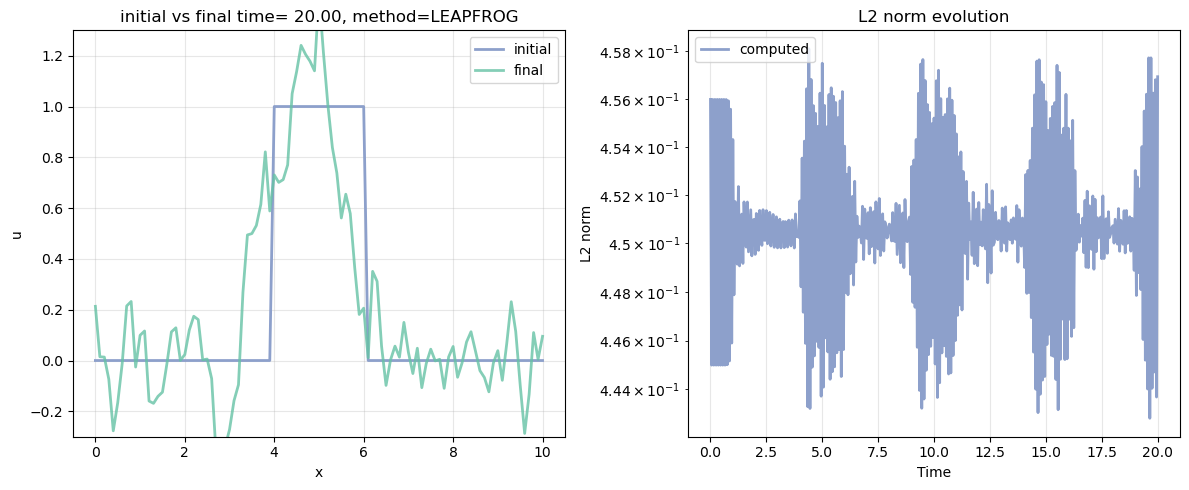

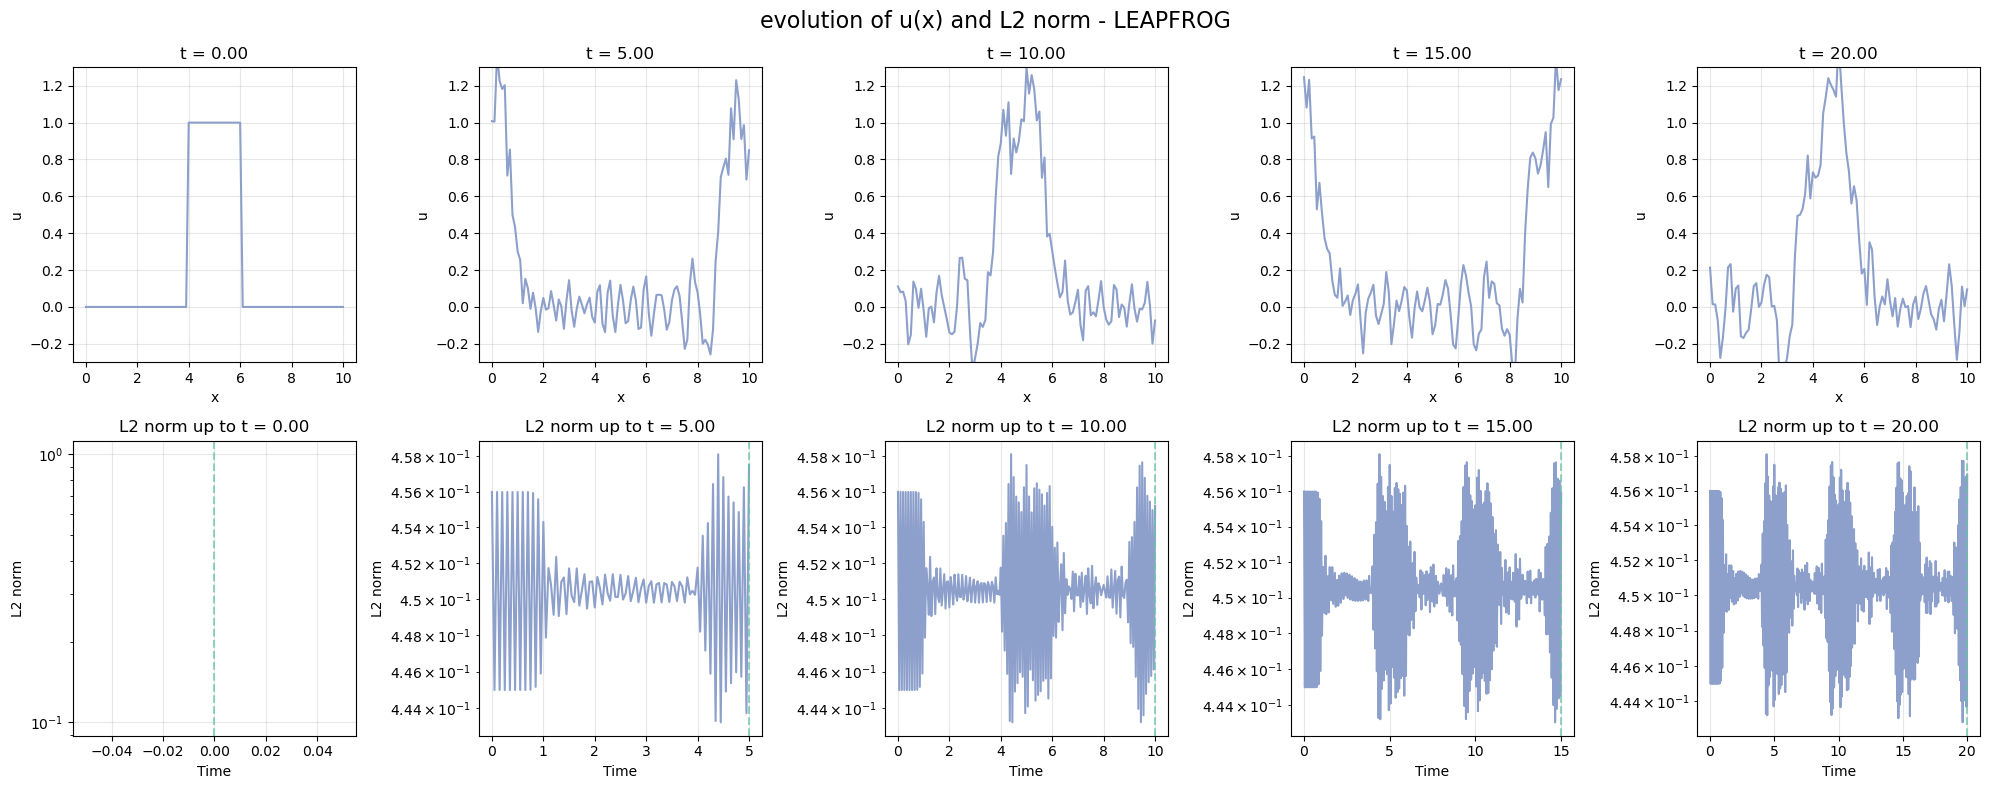

In [97]:
x, u_final, time, l2norm = advection_equation(L=10.0, nx=101, cf=0.5, a=1.0, t_final=20, x0=5, u_initial='step', method='LEAPFROG', plots=True, movie=False, compare_with_saved_data=False)

Running FTCS...


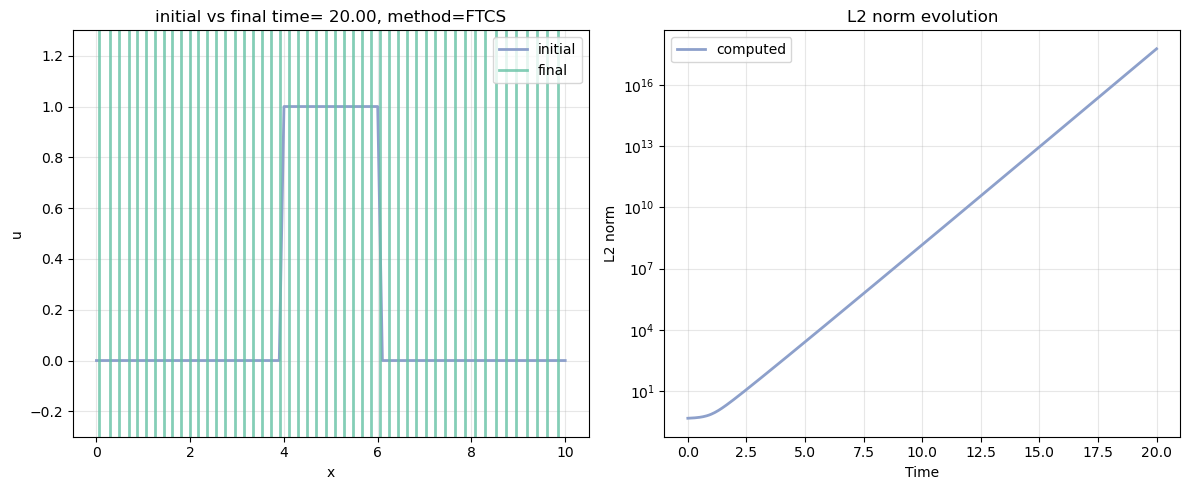

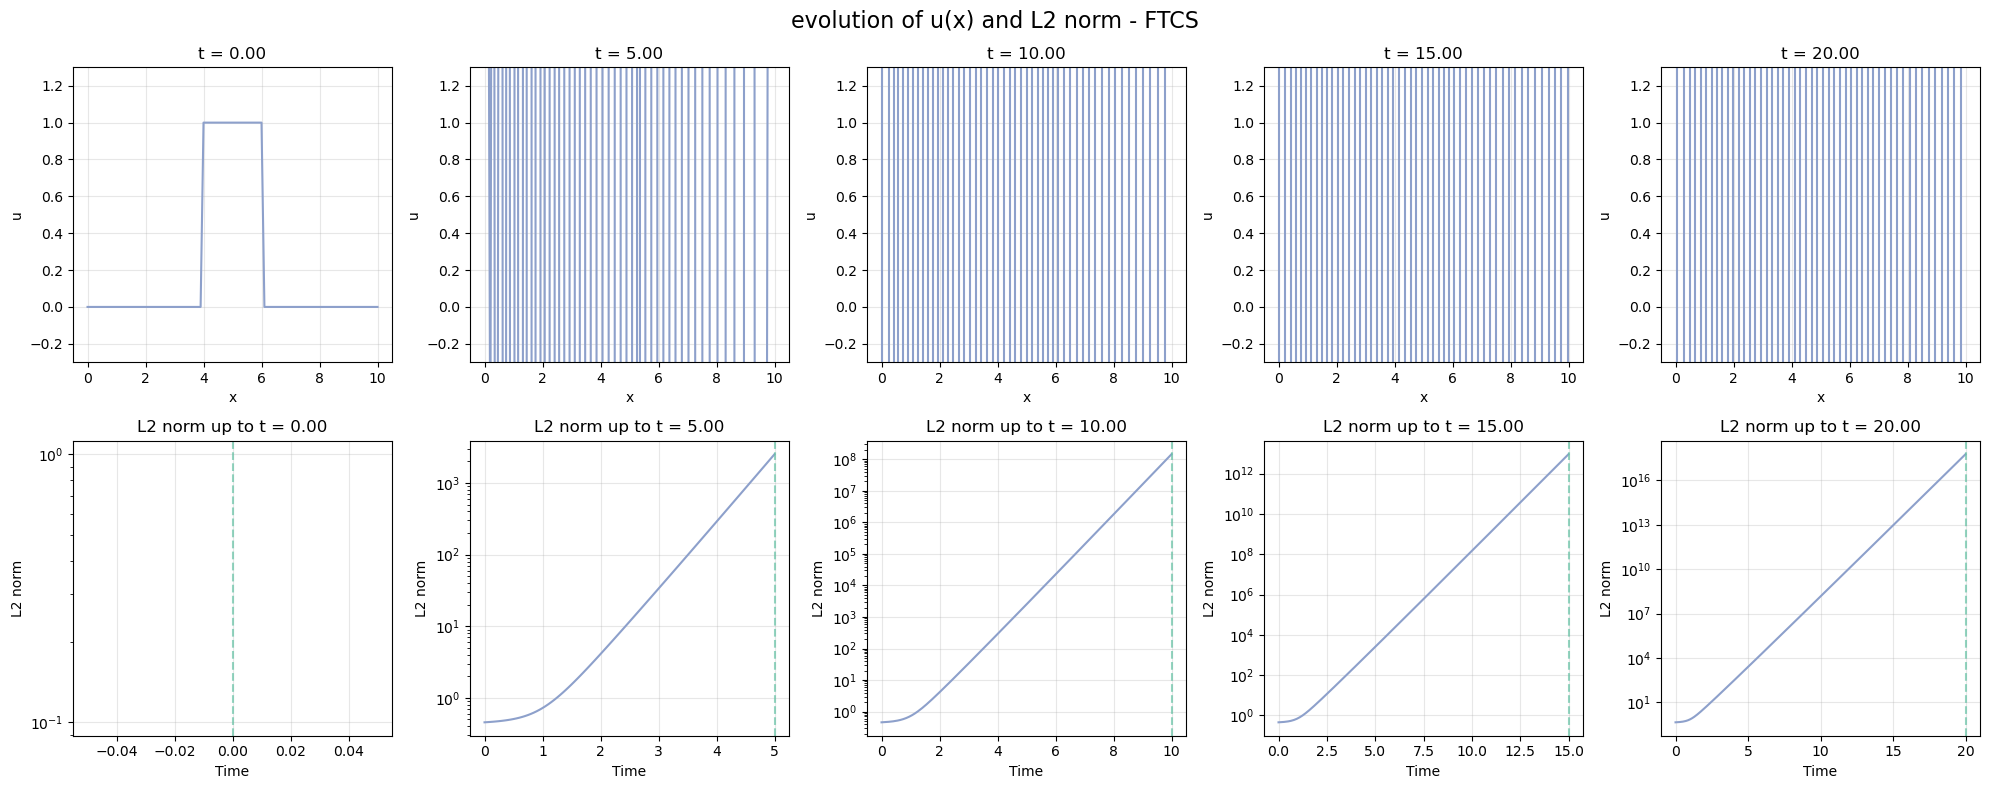

Running LAX-FRIEDRICHS...


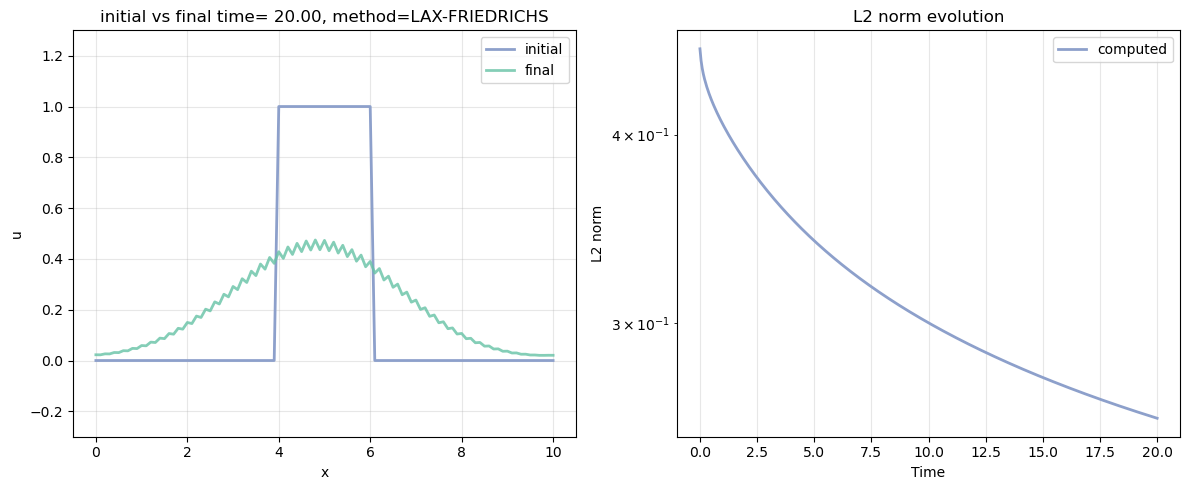

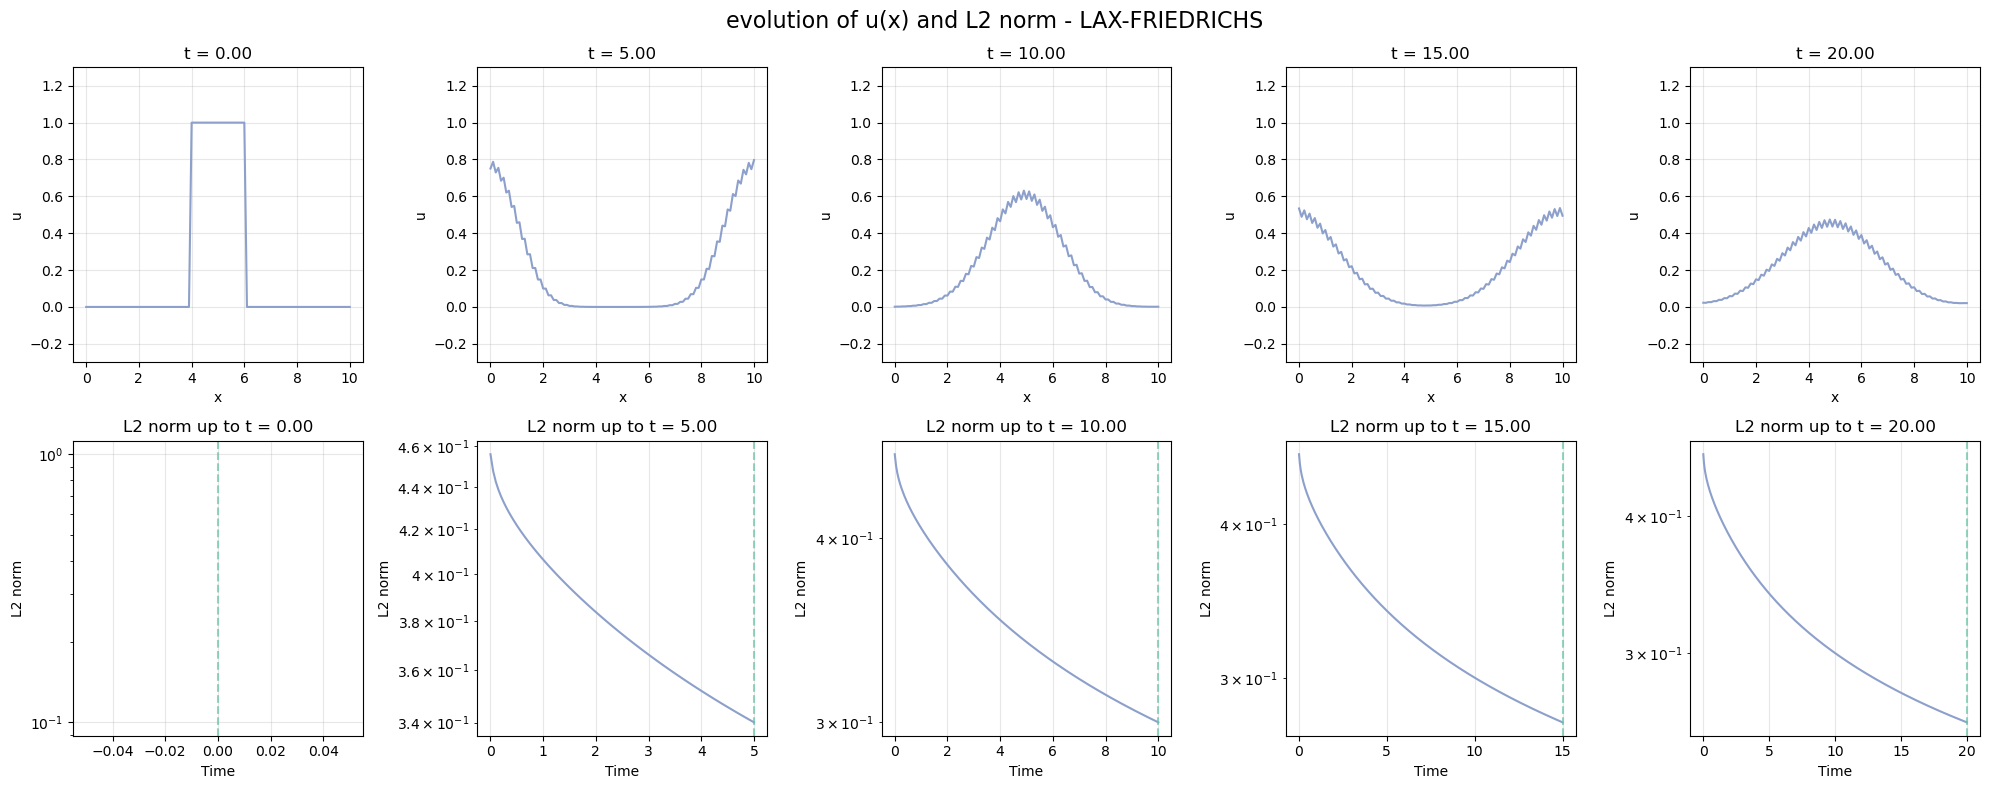

Running LAX-WENDROFF...


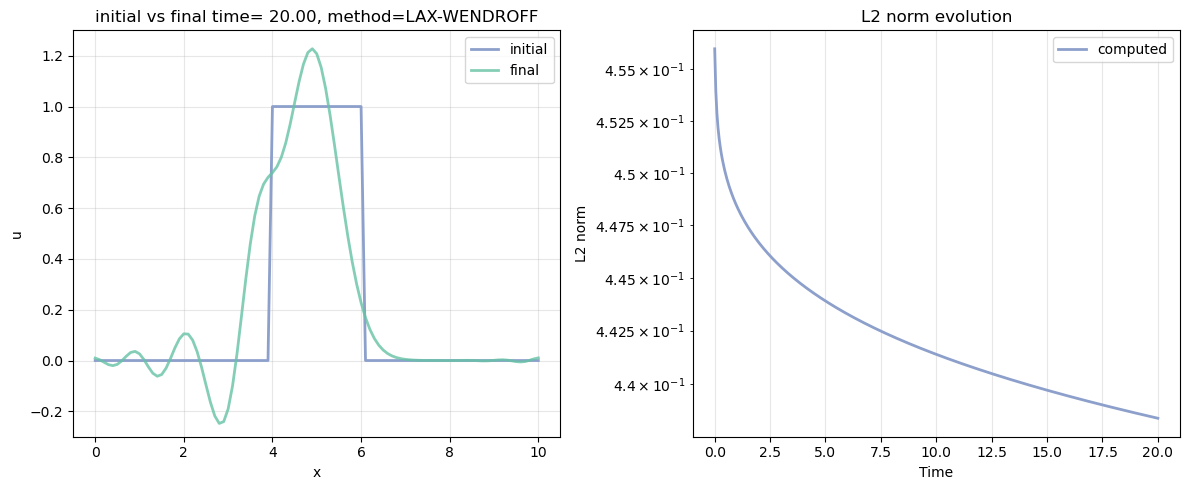

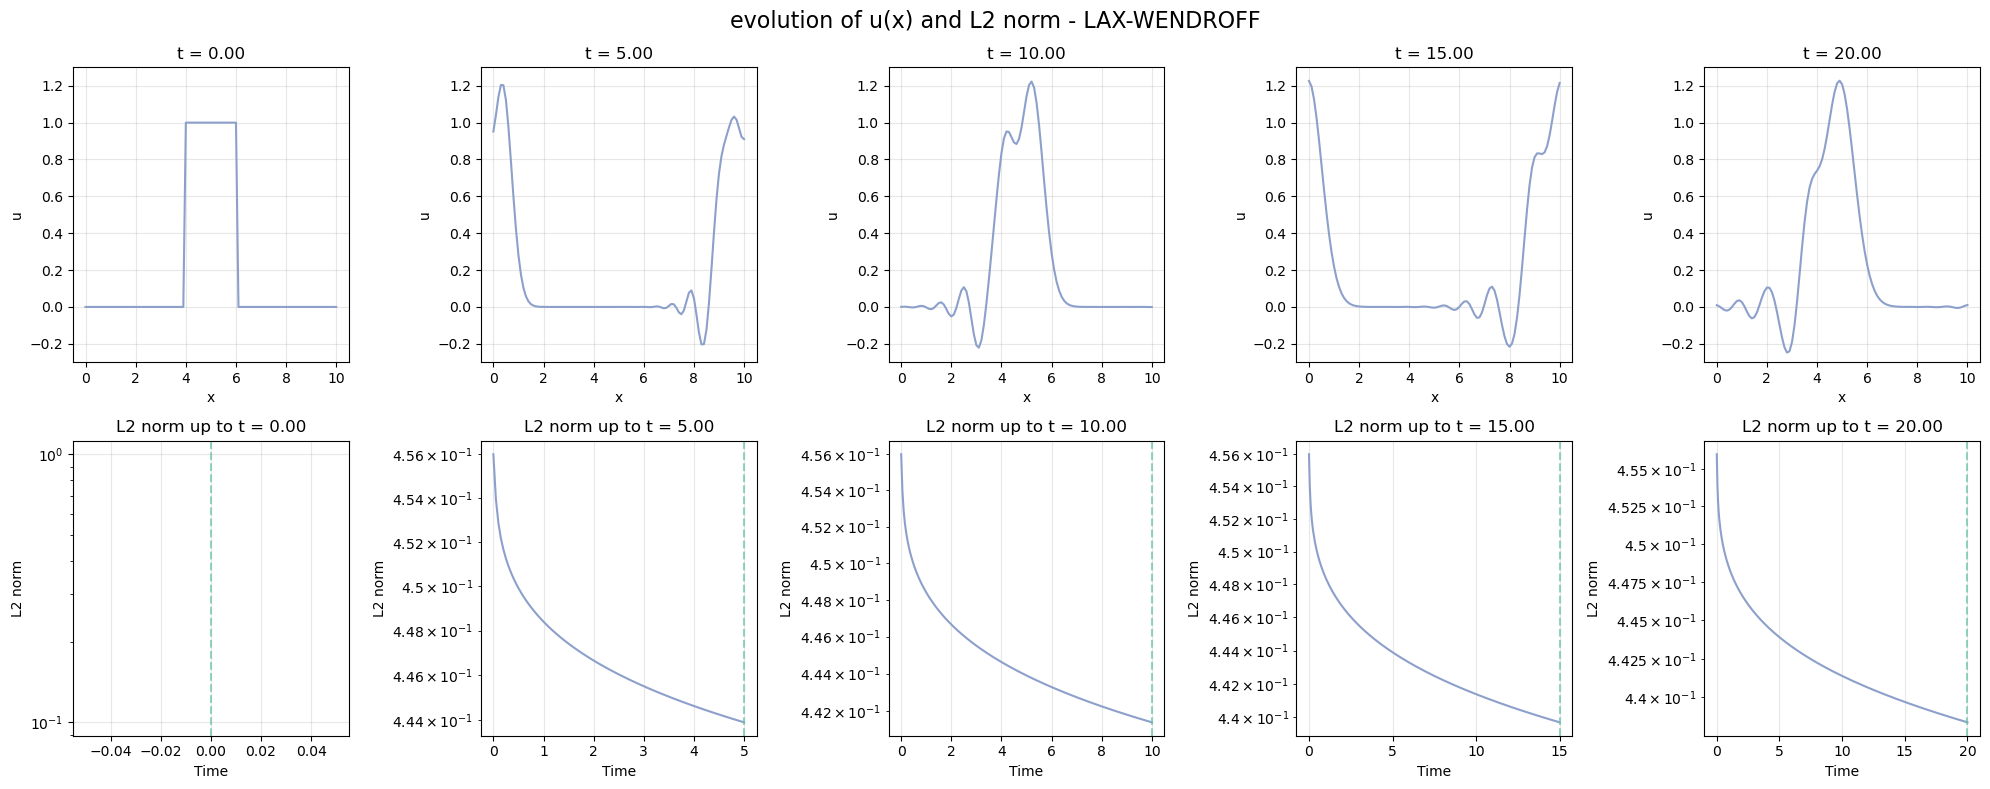

Running LEAPFROG...


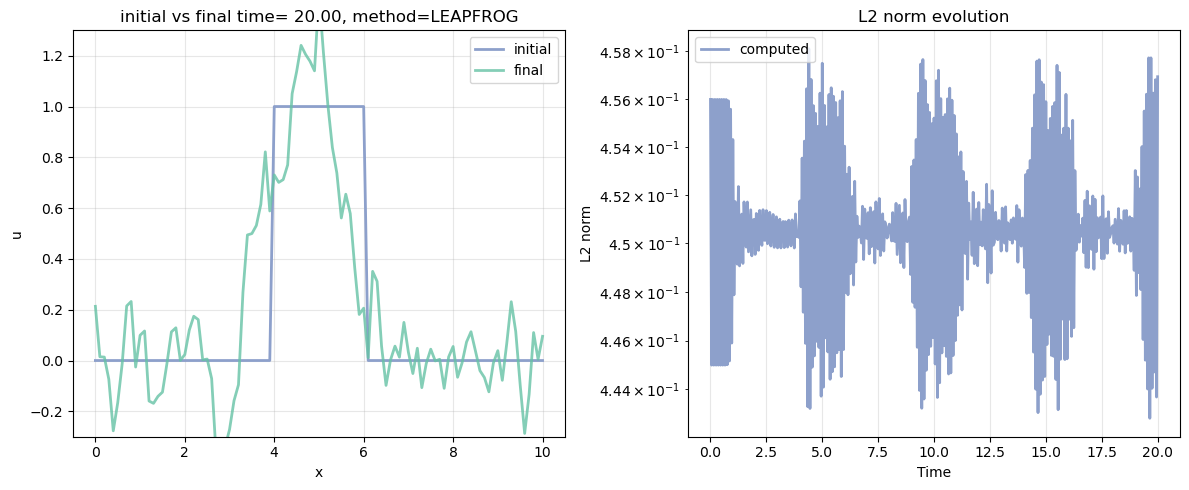

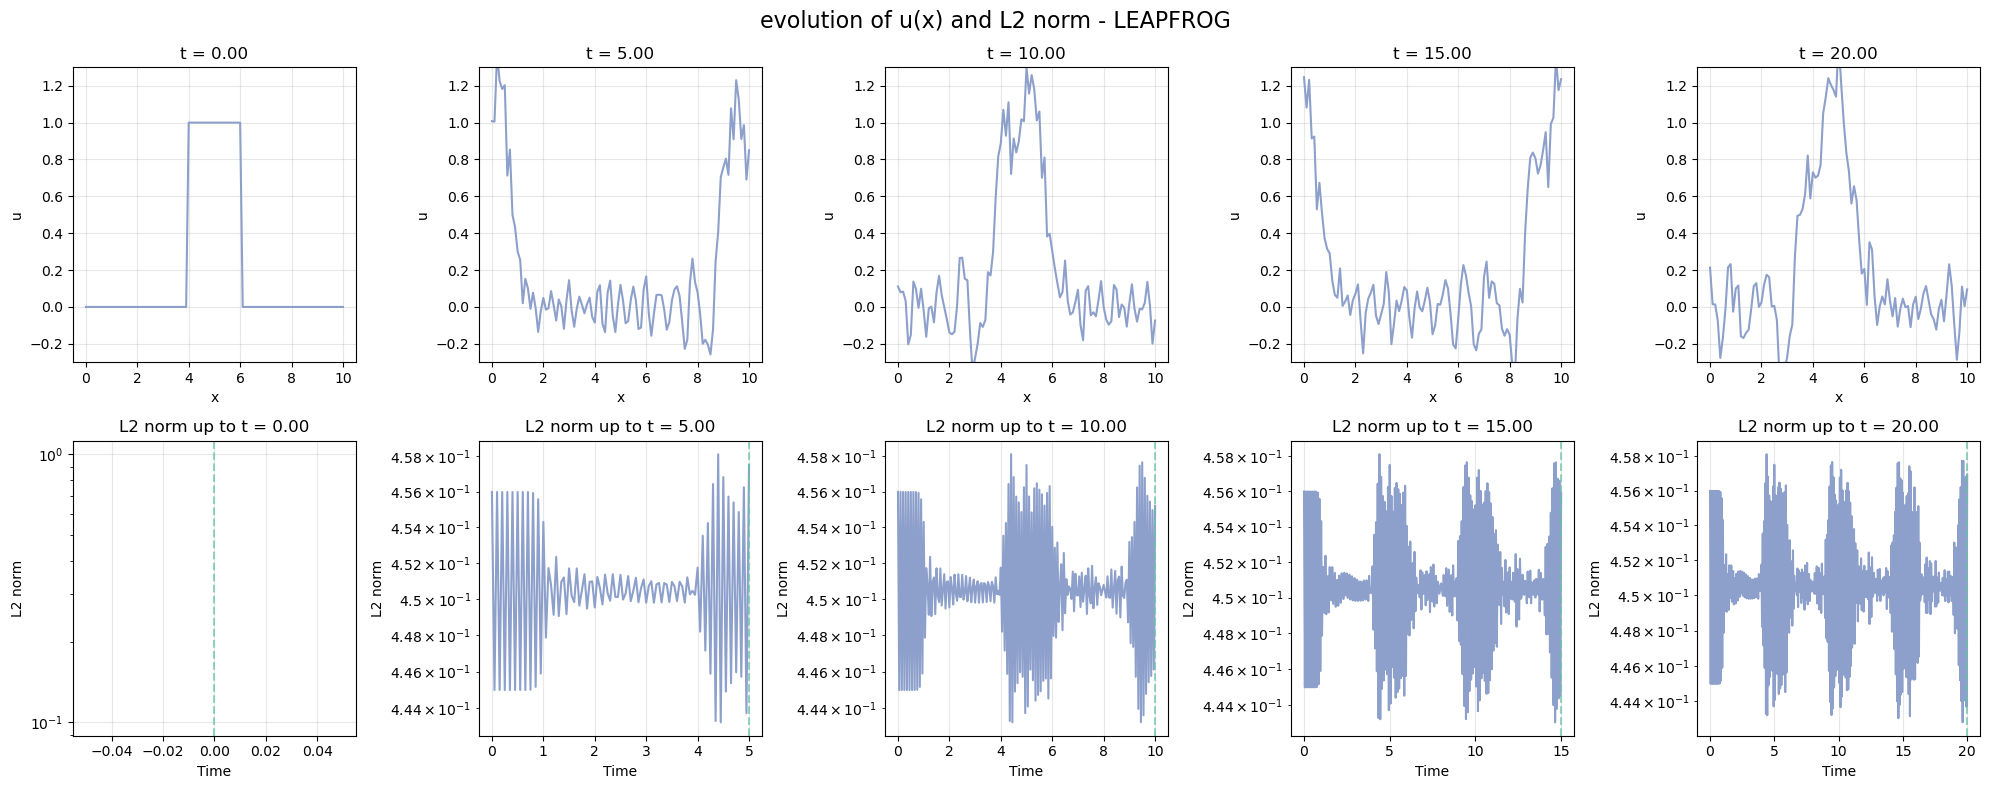

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Set2")

# Run all methods with the same parameters
methods = ['FTCS', 'LAX-FRIEDRICHS', 'LAX-WENDROFF', 'LEAPFROG']
results = {}

# Common parameters
params = {
    'L': 10.0,
    'nx': 101,
    'cf': 0.5,
    'a': 1.0,
    't_final': 20,
    'x0': 5,
    'u_initial': 'step',
    'plots': True,  # Turn off individual plots
    'movie': False,
    'compare_with_saved_data': False
}

# Run all methods
for method in methods:
    print(f"Running {method}...")
    x, u_final, time, l2norm = advection_equation(method=method, **params)
    results[method] = {
        'x': x,
        'u_final': u_final,
        'time': time,
        'l2norm': l2norm
    }


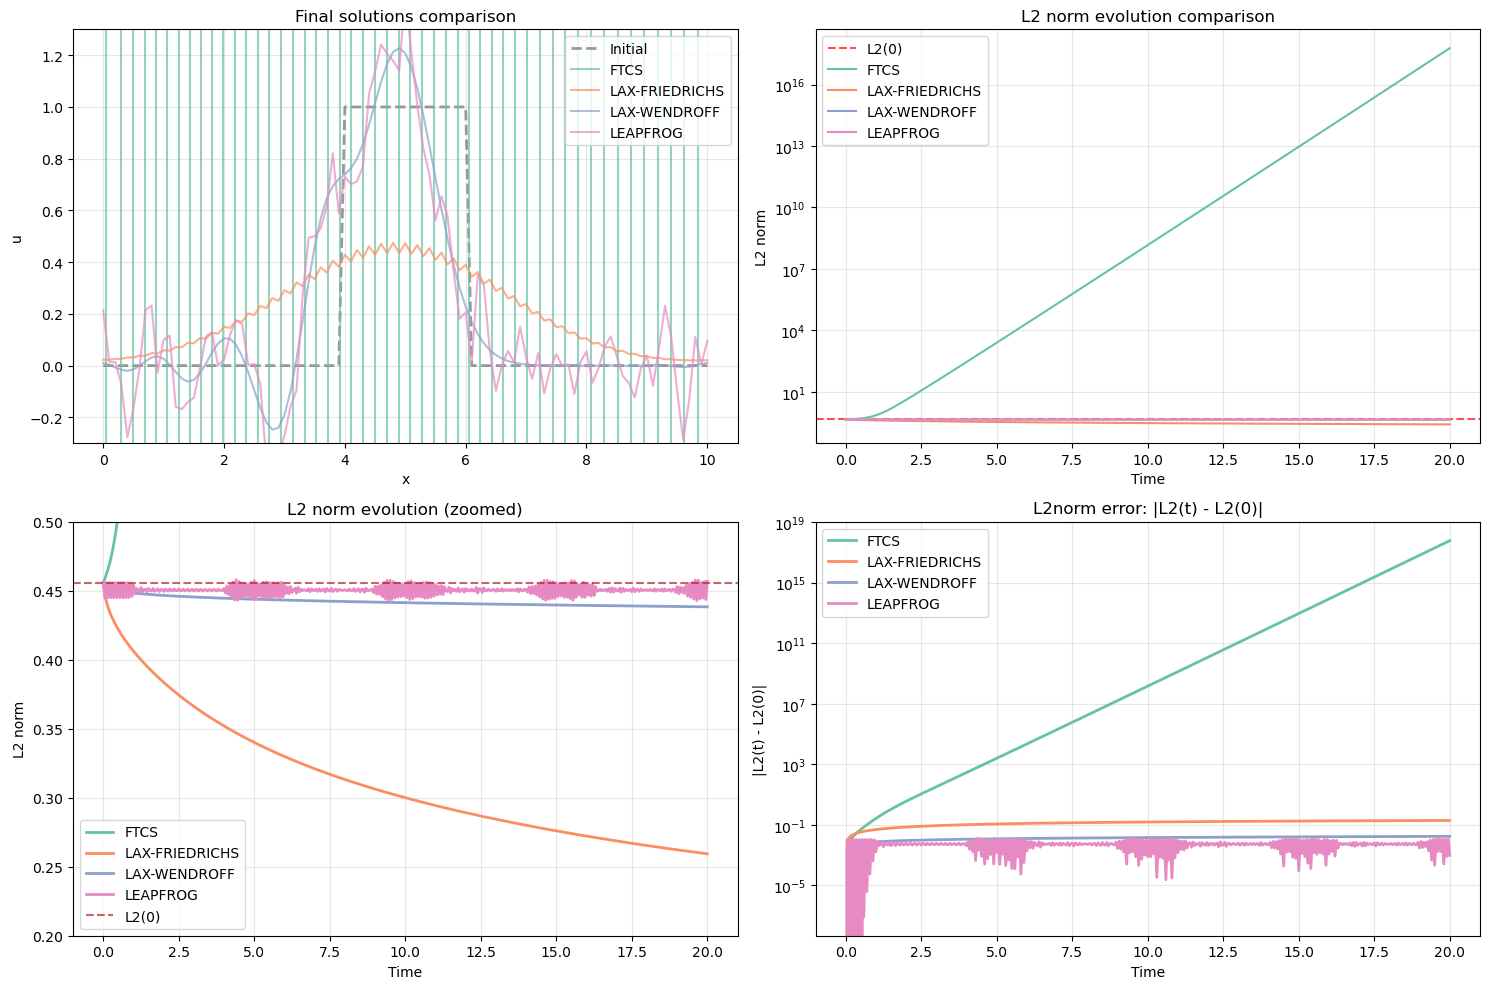


Final L2 norms:
FTCS        : 5.948732e+17
LAX-FRIEDRICHS: 2.593506e-01
LAX-WENDROFF: 4.383877e-01
LEAPFROG    : 4.569350e-01


In [122]:
## IF I WANT TO MAKE COMPARISONS BETWEEN METHODS
u_in= 'step'


fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax1 = axes[0, 0]
if u_in == 'step':
    u_initial = np.zeros_like(x)
    u_initial[(x >= 4) & (x <= 6)] = 1.0
elif u_in == 'gaussian':
    u_initial = np.exp(-((x - params['x0']) ** 2))
ax1.plot(x, u_initial, '--', color='grey', linewidth=2, label='Initial', alpha=0.8)

for i, method in enumerate(methods):
    ax1.plot(results[method]['x'], results[method]['u_final'], 
             color=colors[i], linewidth=1.5,alpha =0.7, label=method)
ax1.set_ylim(-0.3, 1.3)
ax1.set_xlabel('x')
ax1.set_ylabel('u')
ax1.set_title('Final solutions comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
initial_l2 = results[methods[0]]['l2norm'][0]  
ax2.axhline(y=initial_l2, color='red', linestyle='--', alpha=0.7, linewidth=1.5, label='L2(0)')

for i, method in enumerate(methods):
    ax2.plot(results[method]['time'], results[method]['l2norm'], 
             color=colors[i], linewidth=1.5, alpha = 1, label=method)

ax2.set_xlabel('Time')
ax2.set_ylabel('L2 norm')
ax2.set_title('L2 norm evolution comparison')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
for i, method in enumerate(methods):
    ax3.plot(results[method]['time'], results[method]['l2norm'], 
             color=colors[i], linewidth=2, label=method)

ax3.axhline(y=initial_l2, color='firebrick', linestyle='--', alpha=0.7, linewidth=1.5, label='L2(0)')

ax3.set_xlabel('Time')
ax3.set_ylabel('L2 norm')
ax3.set_title('L2 norm evolution (zoomed)')
ax3.set_ylim(0.2, 0.5) 
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
for i, method in enumerate(methods):
    l2_initial = results[method]['l2norm'][0]
    l2_error = np.abs(np.array(results[method]['l2norm']) - l2_initial)
    ax4.plot(results[method]['time'], l2_error, 
             color=colors[i], linewidth=2, label=method)

ax4.set_xlabel('Time')
ax4.set_ylabel('|L2(t) - L2(0)|')
ax4.set_title('L2norm error: |L2(t) - L2(0)|')
ax4.set_yscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal L2 norms:")
for method in methods:
    final_l2 = results[method]['l2norm'][-1]
    print(f"{method:12}: {final_l2:.6e}")

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Set2")

def advection_equation_parameter_comparisons(methods=['FTCS', 'LAX-FRIEDRICHS', 'LAX-WENDROFF', 'LEAPFROG'],
                                           cf_values=[0.1, 0.5, 0.9, 1.0],
                                           nx_values=[51, 101, 201],
                                           L=10.0, a=1.0, t_final=20, x0=5, 
                                           u_initial='gauss', fixed_param='cf', 
                                           fixed_value=0.5):

    if fixed_param == 'cf':
        vary_values = nx_values
        vary_label = 'nx'
        fixed_label = f'cf = {fixed_value}'
    else:
        vary_values = cf_values
        vary_label = 'cf'
        fixed_label = f'nx = {int(fixed_value)}'
    
    results = {}
    
    for method in methods:
        results[method] = {}
        
        for vary_val in vary_values:
            if fixed_param == 'cf':
                cf = fixed_value
                nx = int(vary_val)
            else:
                cf = vary_val
                nx = int(fixed_value)
            
            print(f"Running {method} with cf={cf}, nx={nx}")
            
            x, u_final, time, l2norm = advection_equation(
                L=L, nx=nx, cf=cf, a=a, t_final=t_final, x0=x0,
                u_initial=u_initial, method=method, plots=False, 
                movie=False, compare_with_saved_data=False
            )
            
            results[method][vary_val] = {
                'x': x,
                'u_final': u_final,
                'time': time,
                'l2norm': l2norm,
                'cf': cf,
                'nx': nx
            }
    
    x_ref = np.linspace(0, 10, 101)
    if u_initial == 'gaussian':
        u_initial_ref = np.exp(-((x_ref - 5) ** 2))
    else:
        u_initial_ref = np.zeros_like(x_ref)
        u_initial_ref[(x_ref >= 4) & (x_ref <= 6)] = 1.0
    
    fig, axes = plt.subplots(len(methods), len(vary_values), 
                            figsize=(4*len(vary_values), 3*len(methods)))
    
    if len(methods) == 1:
        axes = axes.reshape(1, -1)
    if len(vary_values) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, method in enumerate(methods):
        for j, vary_val in enumerate(vary_values):
            ax = axes[i, j]
            data = results[method][vary_val]
            
            ax.plot(x_ref, u_initial_ref, '--', color='gray', alpha=0.7, 
                    label='initial', linewidth=1)
            ax.plot(data['x'], data['u_final'], color=colors[i], 
                    linewidth=2, label='final')
            
            ax.set_title(f'{method}, {vary_label} = {vary_val}')
            ax.set_ylim(-0.3, 1.3)
            ax.grid(True, alpha=0.3)
            
            if j == 0:
                ax.set_ylabel('u')
            if i == len(methods) - 1:
                ax.set_xlabel('x')
            if i == 0 and j == 0:
                ax.legend()
    
    plt.suptitle(f'Final solutions at t={t_final} ({fixed_label})', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(len(methods), 1, figsize=(10, 3*len(methods)))
    
    if len(methods) == 1:
        axes = [axes]
    
    for i, method in enumerate(methods):
        ax = axes[i]
        
        for j, vary_val in enumerate(vary_values):
            data = results[method][vary_val]
            
            ax.plot(data['time'], data['l2norm'], color=colors[j], 
                    linewidth=2, label=f'{vary_label} = {vary_val}')
        
        ax.set_yscale('log')
        ax.set_xlabel('Time')
        ax.set_ylabel('L2 norm')
        ax.set_title(f'{method} - L2 norm evolution')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'L2 norm evolution ({fixed_label})', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return results

Running FTCS with cf=0.1, nx=101
Running FTCS with cf=0.5, nx=101
Running FTCS with cf=0.9, nx=101
Running FTCS with cf=1.0, nx=101
Running FTCS with cf=1.1, nx=101
Running LAX-FRIEDRICHS with cf=0.1, nx=101
Running LAX-FRIEDRICHS with cf=0.5, nx=101
Running LAX-FRIEDRICHS with cf=0.9, nx=101
Running LAX-FRIEDRICHS with cf=1.0, nx=101
Running LAX-FRIEDRICHS with cf=1.1, nx=101
Running LAX-WENDROFF with cf=0.1, nx=101
Running LAX-WENDROFF with cf=0.5, nx=101
Running LAX-WENDROFF with cf=0.9, nx=101
Running LAX-WENDROFF with cf=1.0, nx=101
Running LAX-WENDROFF with cf=1.1, nx=101
Running LEAPFROG with cf=0.1, nx=101
Running LEAPFROG with cf=0.5, nx=101
Running LEAPFROG with cf=0.9, nx=101
Running LEAPFROG with cf=1.0, nx=101
Running LEAPFROG with cf=1.1, nx=101


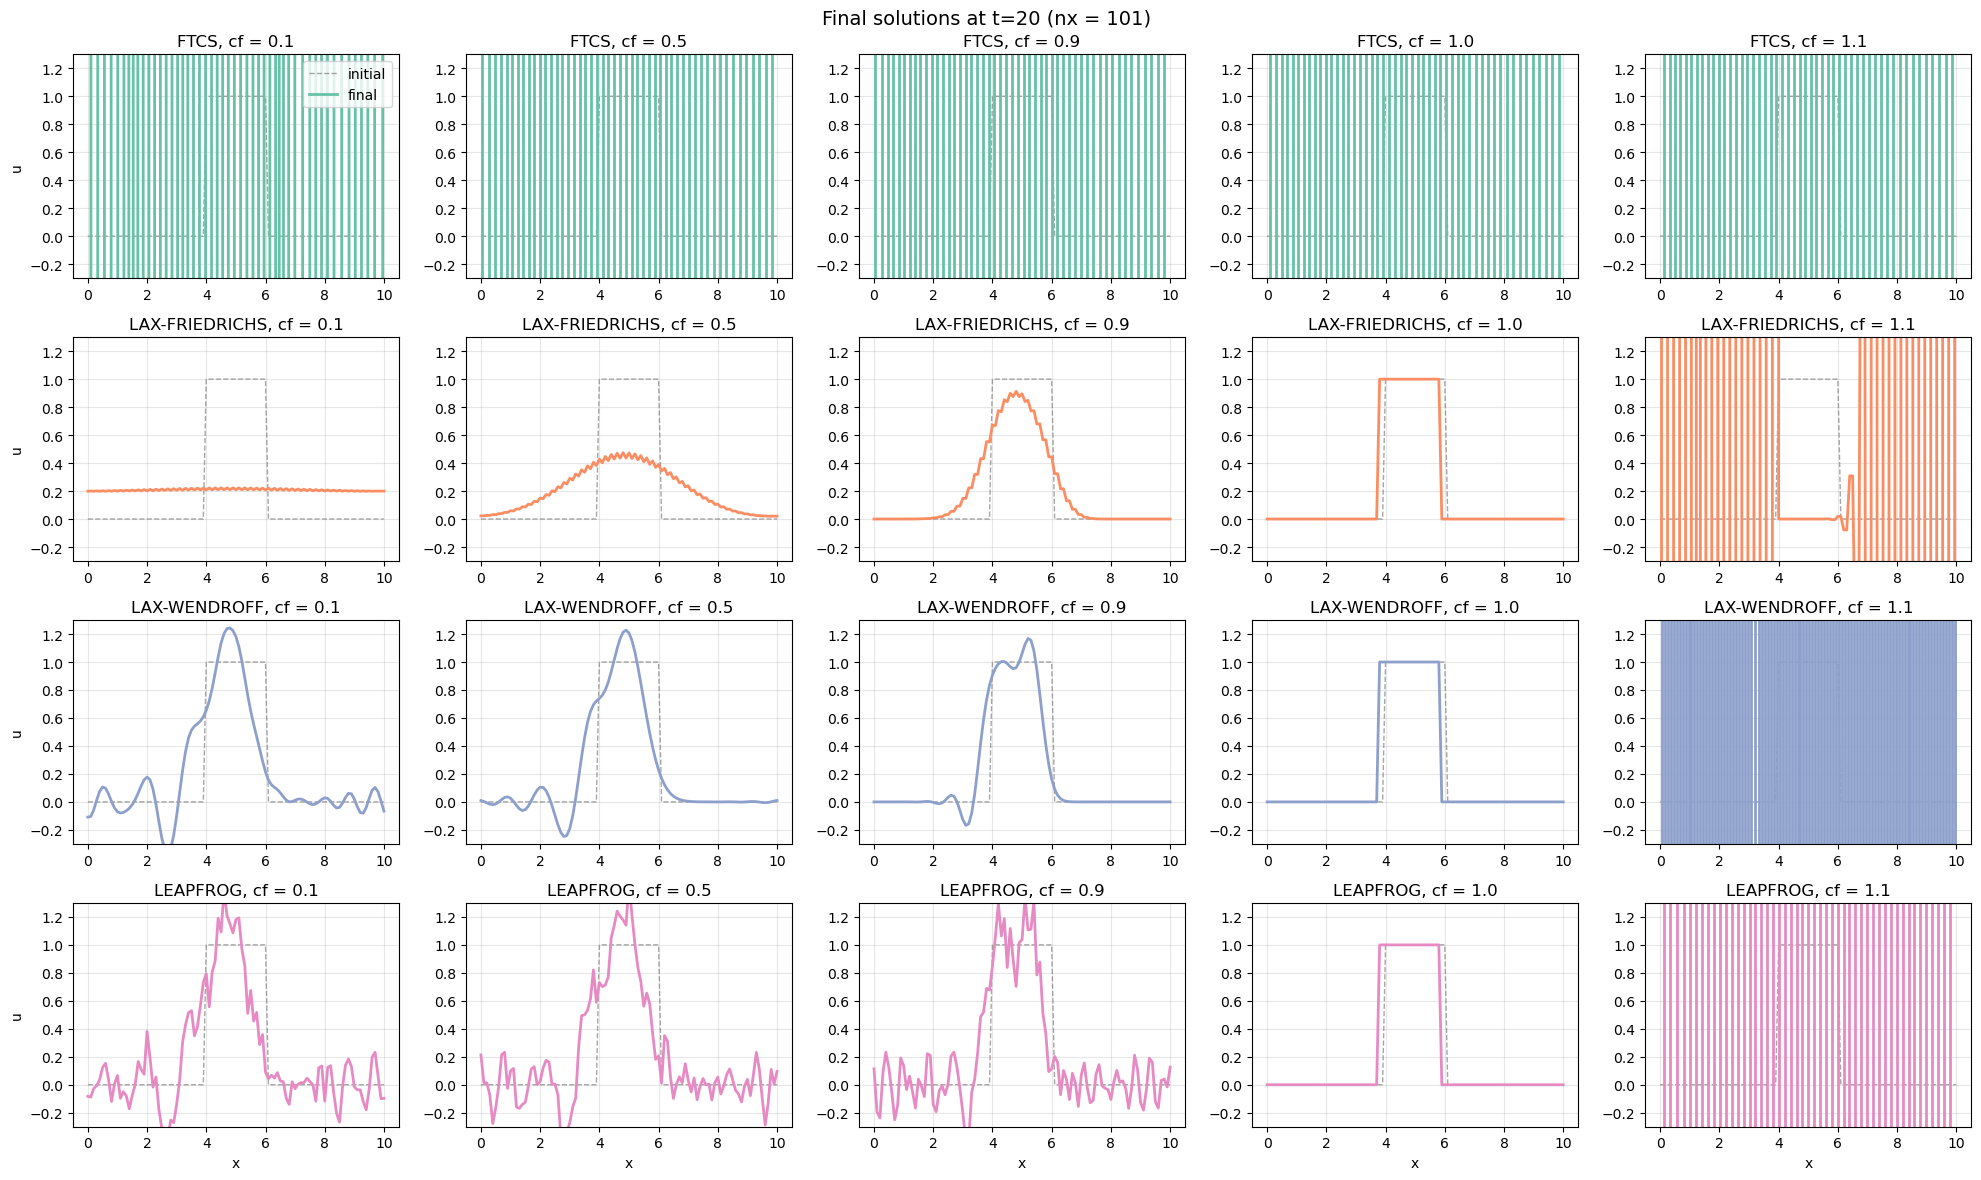

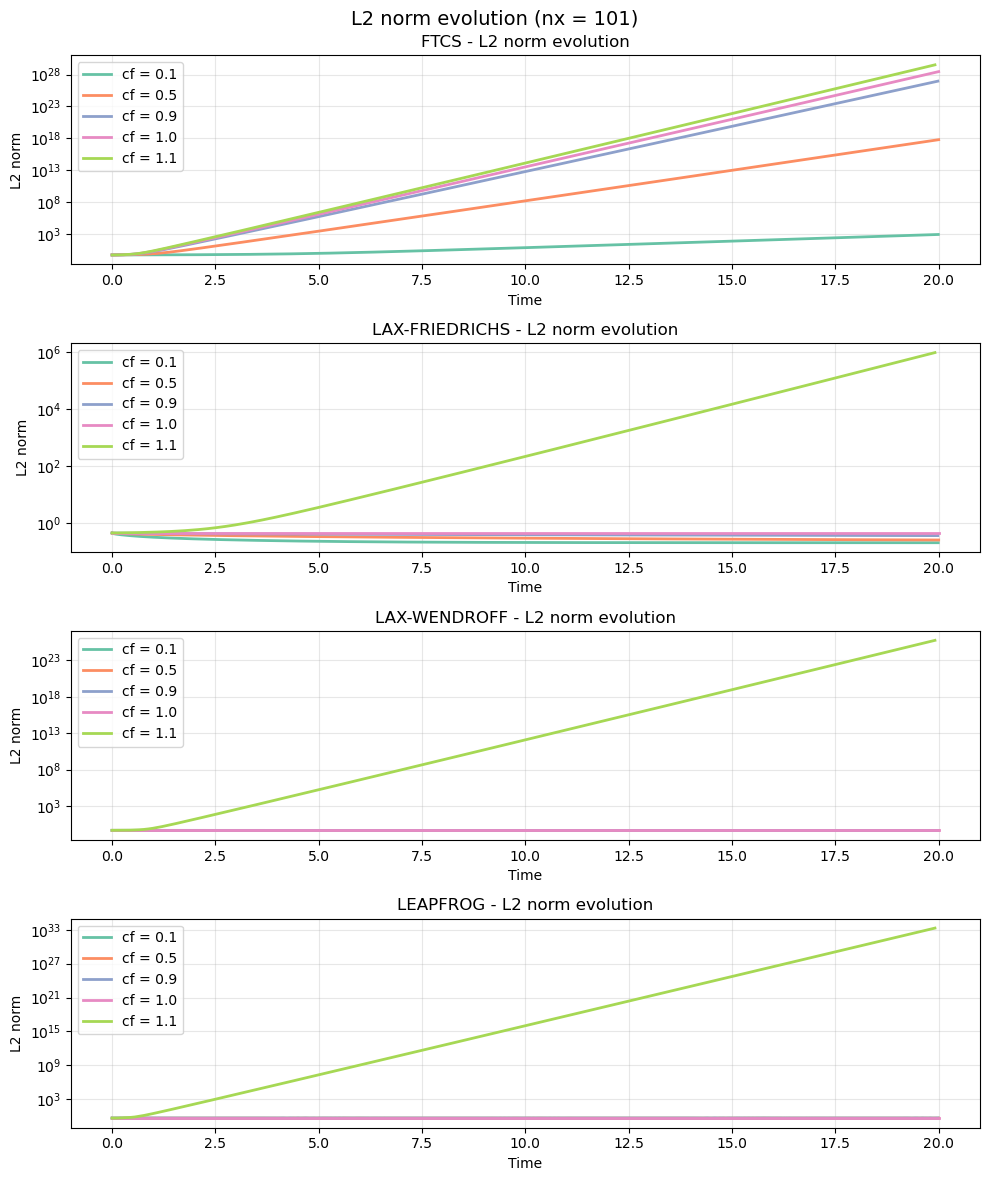

Running FTCS with cf=0.5, nx=51
Running FTCS with cf=0.5, nx=101
Running FTCS with cf=0.5, nx=201
Running FTCS with cf=0.5, nx=401
Running LAX-FRIEDRICHS with cf=0.5, nx=51
Running LAX-FRIEDRICHS with cf=0.5, nx=101
Running LAX-FRIEDRICHS with cf=0.5, nx=201
Running LAX-FRIEDRICHS with cf=0.5, nx=401
Running LAX-WENDROFF with cf=0.5, nx=51
Running LAX-WENDROFF with cf=0.5, nx=101
Running LAX-WENDROFF with cf=0.5, nx=201
Running LAX-WENDROFF with cf=0.5, nx=401
Running LEAPFROG with cf=0.5, nx=51
Running LEAPFROG with cf=0.5, nx=101
Running LEAPFROG with cf=0.5, nx=201
Running LEAPFROG with cf=0.5, nx=401


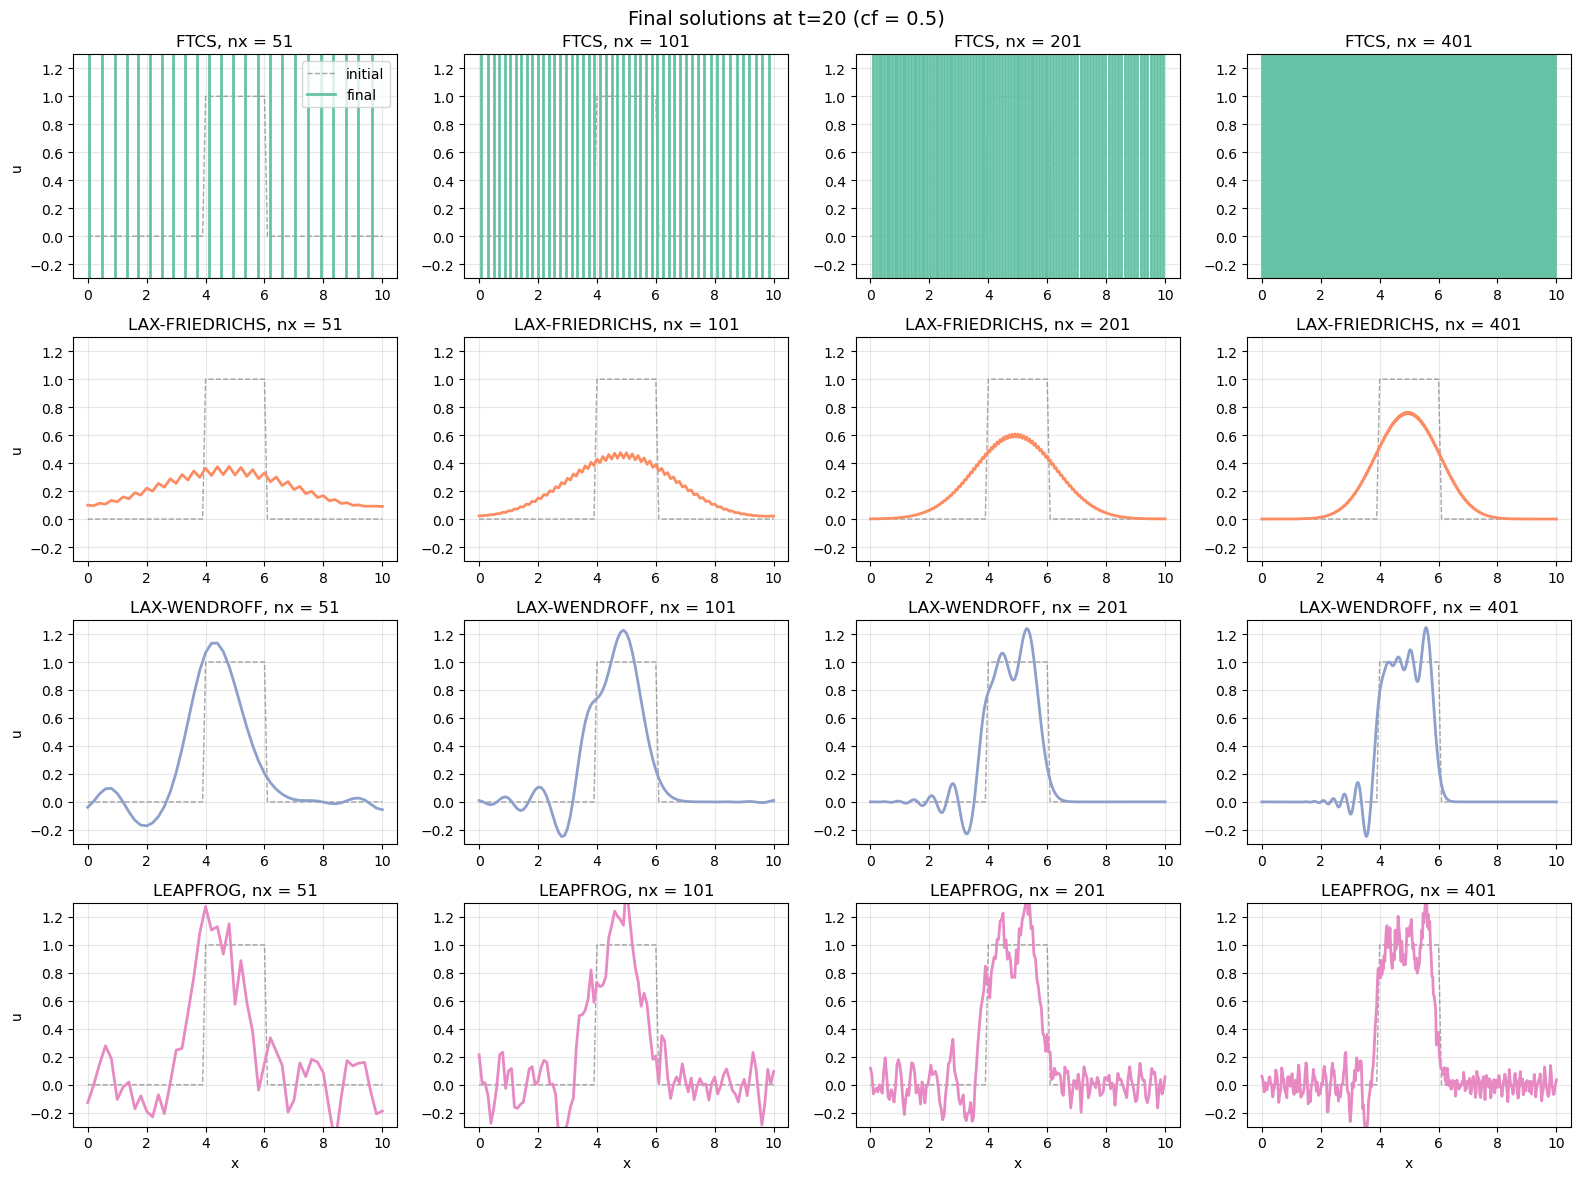

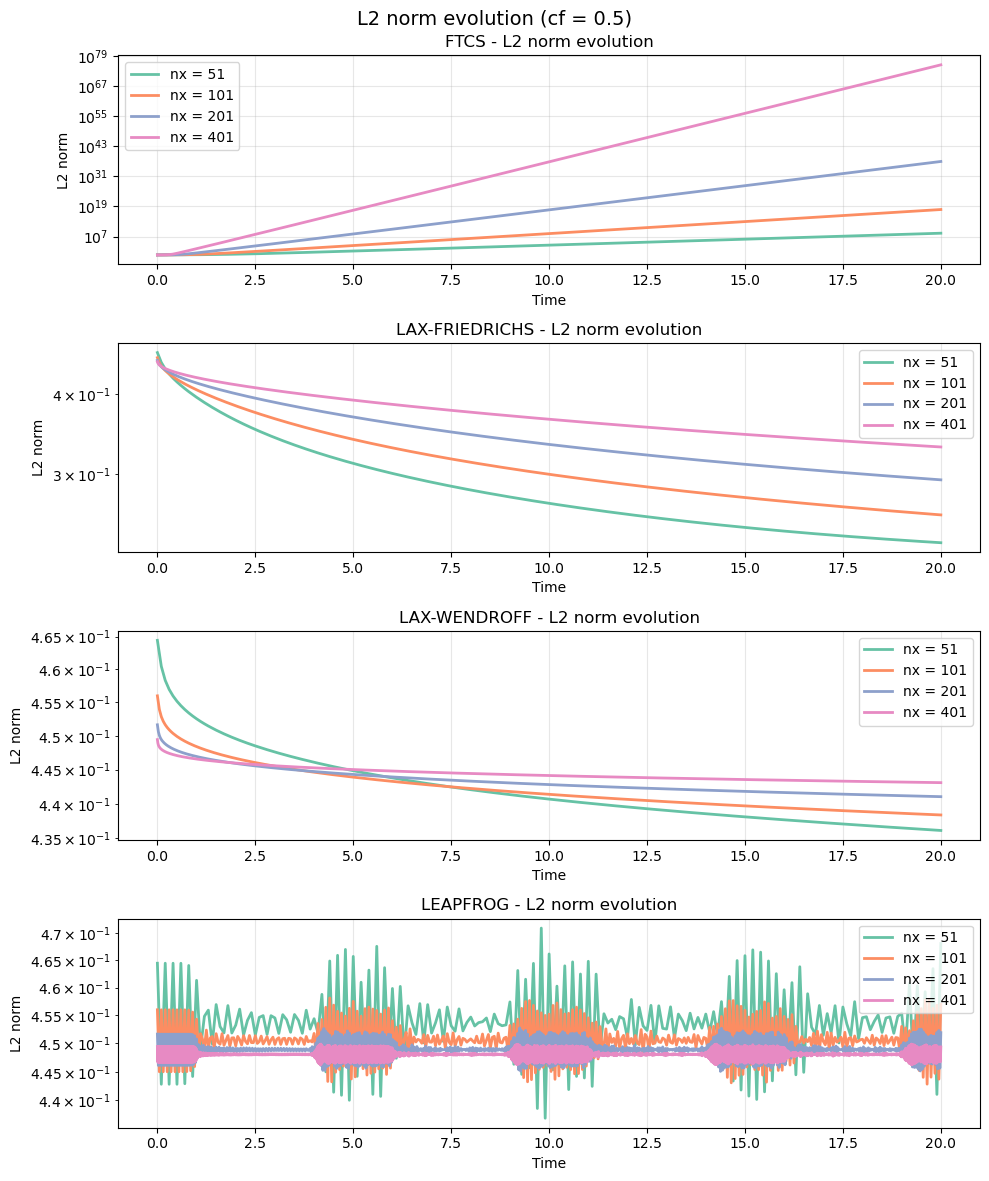

In [117]:
# different cf with fixed nx
results_cf = advection_equation_parameter_comparisons(
    methods=['FTCS', 'LAX-FRIEDRICHS', 'LAX-WENDROFF', 'LEAPFROG'],
    cf_values=[0.1, 0.5, 0.9, 1.0, 1.1],
    fixed_param='nx',
    fixed_value=101,
    u_initial='step'
)

# different nx with fixed cf
results_nx = advection_equation_parameter_comparisons(
    methods=['FTCS', 'LAX-FRIEDRICHS', 'LAX-WENDROFF', 'LEAPFROG'],
    nx_values=[51, 101, 201, 401],
    fixed_param='cf',
    fixed_value=0.5,
    u_initial='step'
)

--------------------------------
------------------------------
# Burgers' equation

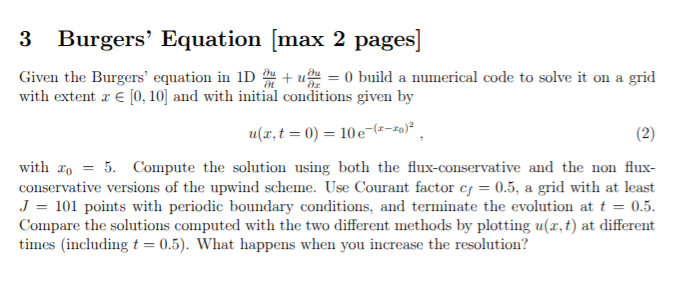

In [147]:
def f(u):
    return 1/2 * u**2

def upwind(u_current, dt, dx, boundary_condition='periodic', flux_conservative=True ):

    if flux_conservative:
        u_next = u_current - dt/(dx)*(f(u_current) - f(np.roll(u_current, 1)) )   

    else:
        u_next = u_current - dt* u_current/(dx)*(u_current - np.roll(u_current, 1)) 

    return u_next


def L2_norm (u_current):
    return np.sqrt(np.sum(u_current**2)/len(u_current))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

colors = sns.color_palette("Set2")

def burgers_equation(L=10.0, nx=101, cf=0.5, a=1.0, t_final=20, x0=5, u_initial='gaussian', method='upwind_flux_cons', plots=True, movie=False):

    dx = L / (nx - 1)
    x = np.linspace(0, L, nx)

    if u_initial == 'gaussian':
        u = 10 * np.exp(-((x - x0) ** 2))
    
    else:
        raise ValueError("Use 'gaussian'.")

    dt = cf * dx / np.max(u)
    n_steps = int(t_final / dt)
    
    u_current = u.copy()
    l2norm = [L2_norm(u_current)]
    time = [0.0]

    snapshot_data = []  
    snapshot_indices = set(np.linspace(0, n_steps, 5, dtype=int).tolist())
    snapshot_indices.add(n_steps)  

    if movie:
        folder_name = "frames/movie/burgers/" + method 
        os.makedirs(folder_name, exist_ok=True)

    t = 0.0
    
    for i in range(n_steps + 1):

        if i in snapshot_indices and plots:
            snapshot_data.append((t, u_current.copy(), l2norm.copy(), time.copy()))

        if movie:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=False)

            ax1.plot(x, u_current, color=colors[0])
            ax1.set_ylabel('u')
            ax1.set_xlabel('x')
            ax1.set_title(f'u(x) at t={t:.2f}')
            ax1.grid()

            ax2.plot(time, l2norm, color=colors[2])
            ax2.set_xlabel('Time')
            ax2.set_ylabel('L2 norm')
            ax2.set_title('L2 Norm Evolution')
            ax2.set_yscale('log')
            ax2.grid()

            plt.tight_layout()
            plt.savefig(folder_name + f"/frame_{i:04d}.png")
            plt.close()

        if i < n_steps:
            if method == 'upwind_flux_cons':
                u_next = upwind(u_current, dt, dx, boundary_condition='periodic', flux_conservative=True)
            elif method == 'upwind_no_flux_cons':
                u_next = upwind(u_current, dt, dx, boundary_condition='periodic', flux_conservative=False)

            else:
                raise ValueError(" Use 'upwind_flux_cons' or 'upwind_no_flux_cons'.")
            
            u_current = u_next.copy()
            t += dt
            time.append(t)
            l2norm.append(L2_norm(u_current))
    if plots:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].plot(x, u, label='initial', color=colors[2], alpha=1, linewidth=2)
        axes[0].plot(x, u_current, label='final', color=colors[0], alpha=0.8, linewidth=2)
        axes[0].set_title(f'initial vs final time= {t:.2f}, method={method}')
        axes[0].set_ylim(-0.3, 11)
        axes[0].set_xlabel('x')
        axes[0].set_ylabel('u')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        l2norm_plot = l2norm
        ylabel = 'L2 norm'
        title = 'L2 norm evolution'
        
        axes[1].plot(time, l2norm_plot, color=colors[2], linewidth=2, label='computed')
        
        axes[1].set_yscale('log')
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel(ylabel)
        axes[1].set_title(title)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    if plots:
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        
        for i, (tt, uu, l2_history, time_history) in enumerate(snapshot_data):
            if i < 5:  
                axes[0, i].plot(x, uu, color=colors[2], linewidth=1.5)
                axes[0, i].set_title(f't = {tt:.2f}')
                axes[0, i].grid(True, alpha=0.3)
                axes[0, i].set_ylim(-0.3, 11)
                axes[0, i].set_xlabel('x')
                axes[0, i].set_ylabel('u')
        
        for i, (tt, uu, l2_history, time_history) in enumerate(snapshot_data):
            if i < 5:  
                axes[1, i].plot(time_history, l2_history, color=colors[2], linewidth=1.5)
                axes[1, i].set_title(f'L2 norm up to t = {tt:.2f}')
                axes[1, i].grid(True, alpha=0.3)
                axes[1, i].set_yscale('log')
                axes[1, i].set_xlabel('Time')
                axes[1, i].set_ylabel('L2 norm')
                
                axes[1, i].axvline(x=tt, color=colors[0], linestyle='--', alpha=0.7)
        
        plt.suptitle(f'evolution of u(x) and L2 norm - {method}', fontsize=16)
        plt.tight_layout()
        plt.show()

    if movie:
        
        import imageio
      
        frame_files = sorted([f for f in os.listdir(folder_name) if f.endswith('.png')])

        with imageio.get_writer(folder_name + ".gif", mode='I', duration=0.5) as writer:
            for fname in frame_files:
                image = imageio.imread(os.path.join(folder_name, fname))
                writer.append_data(image)

    return x, u_current, time, l2norm

Running upwind_flux_cons...


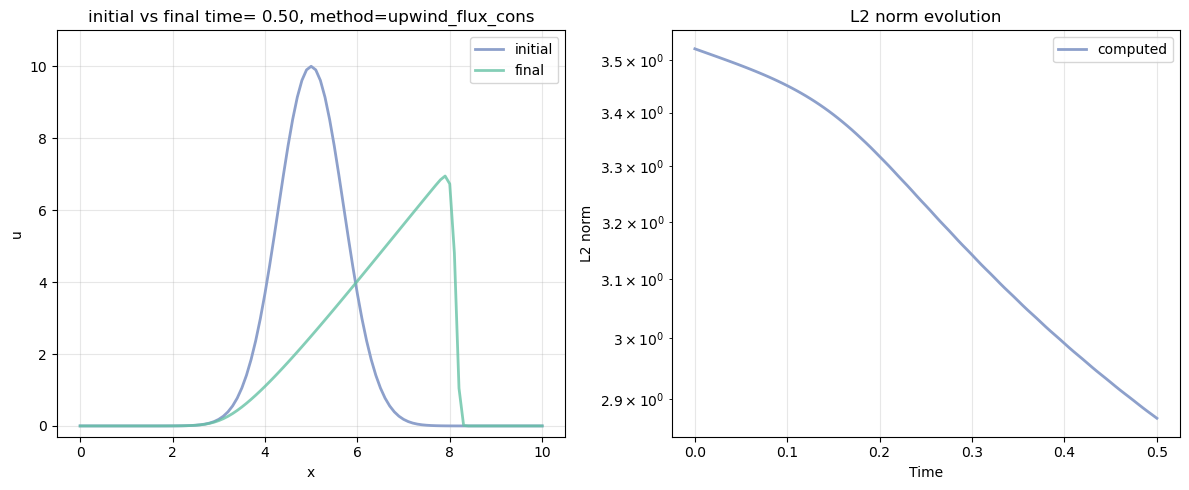

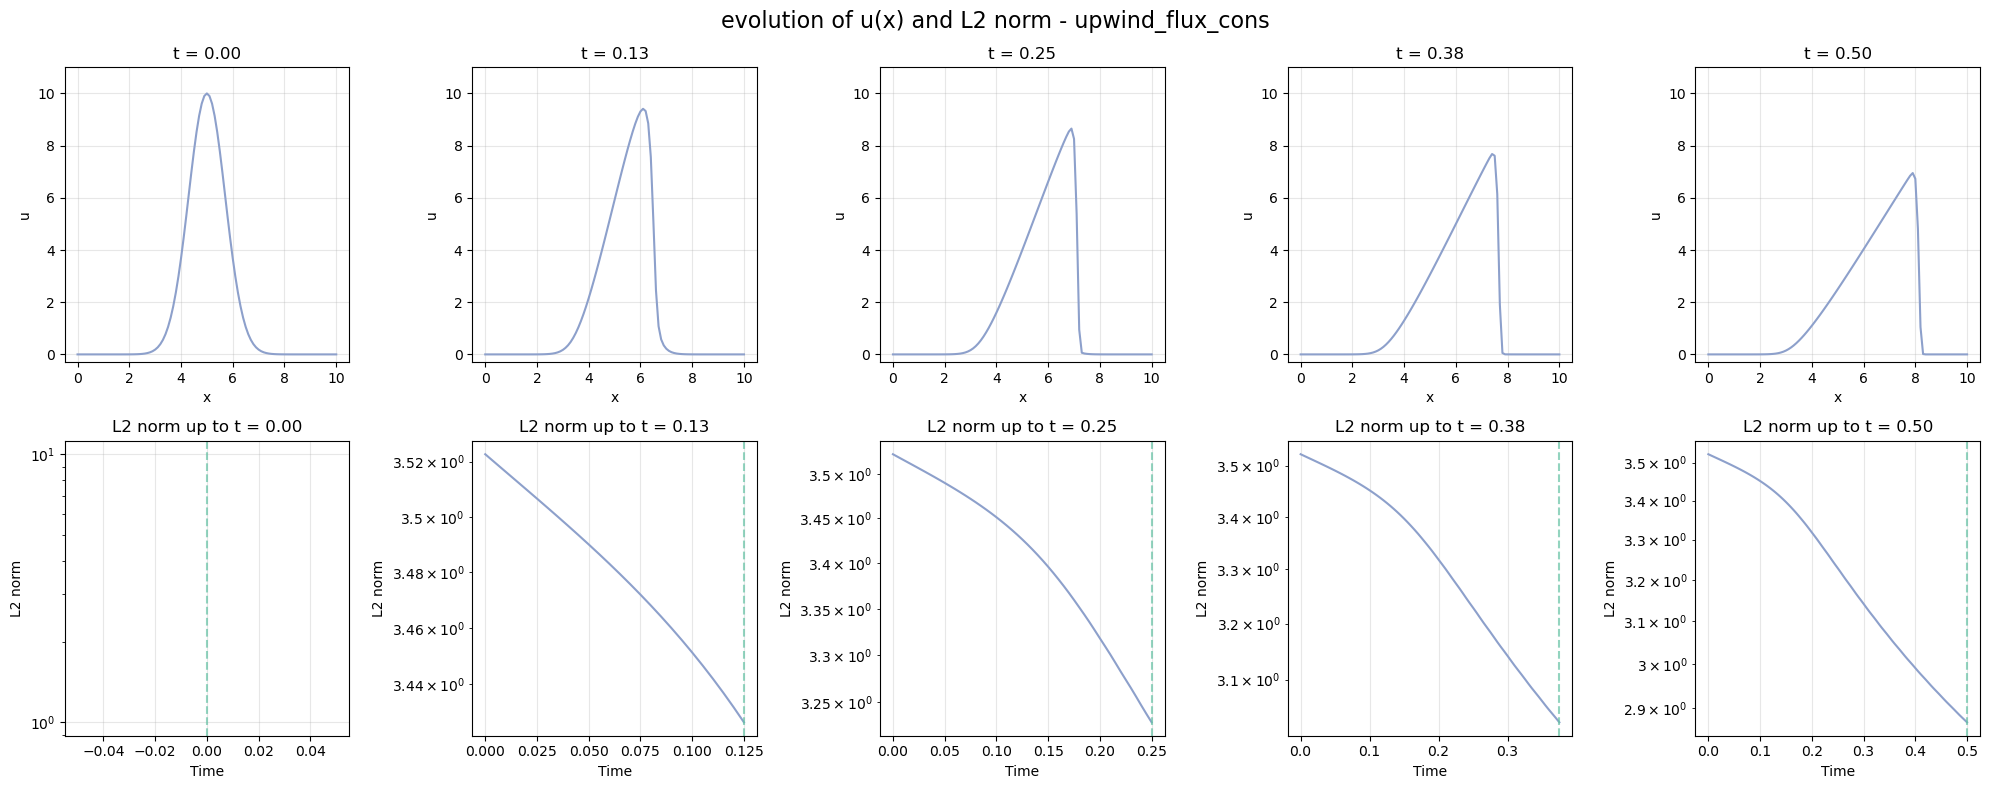

Running upwind_no_flux_cons...


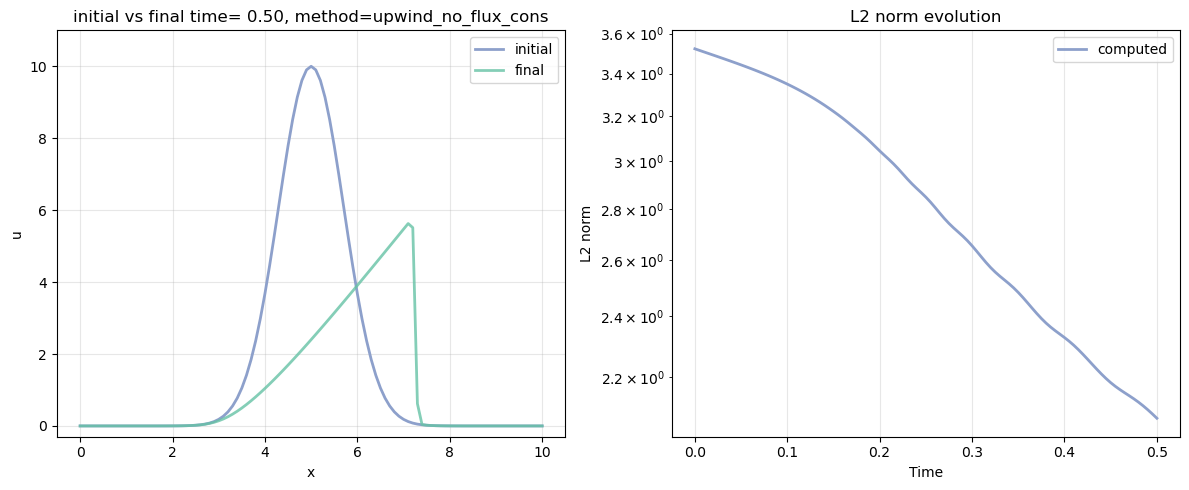

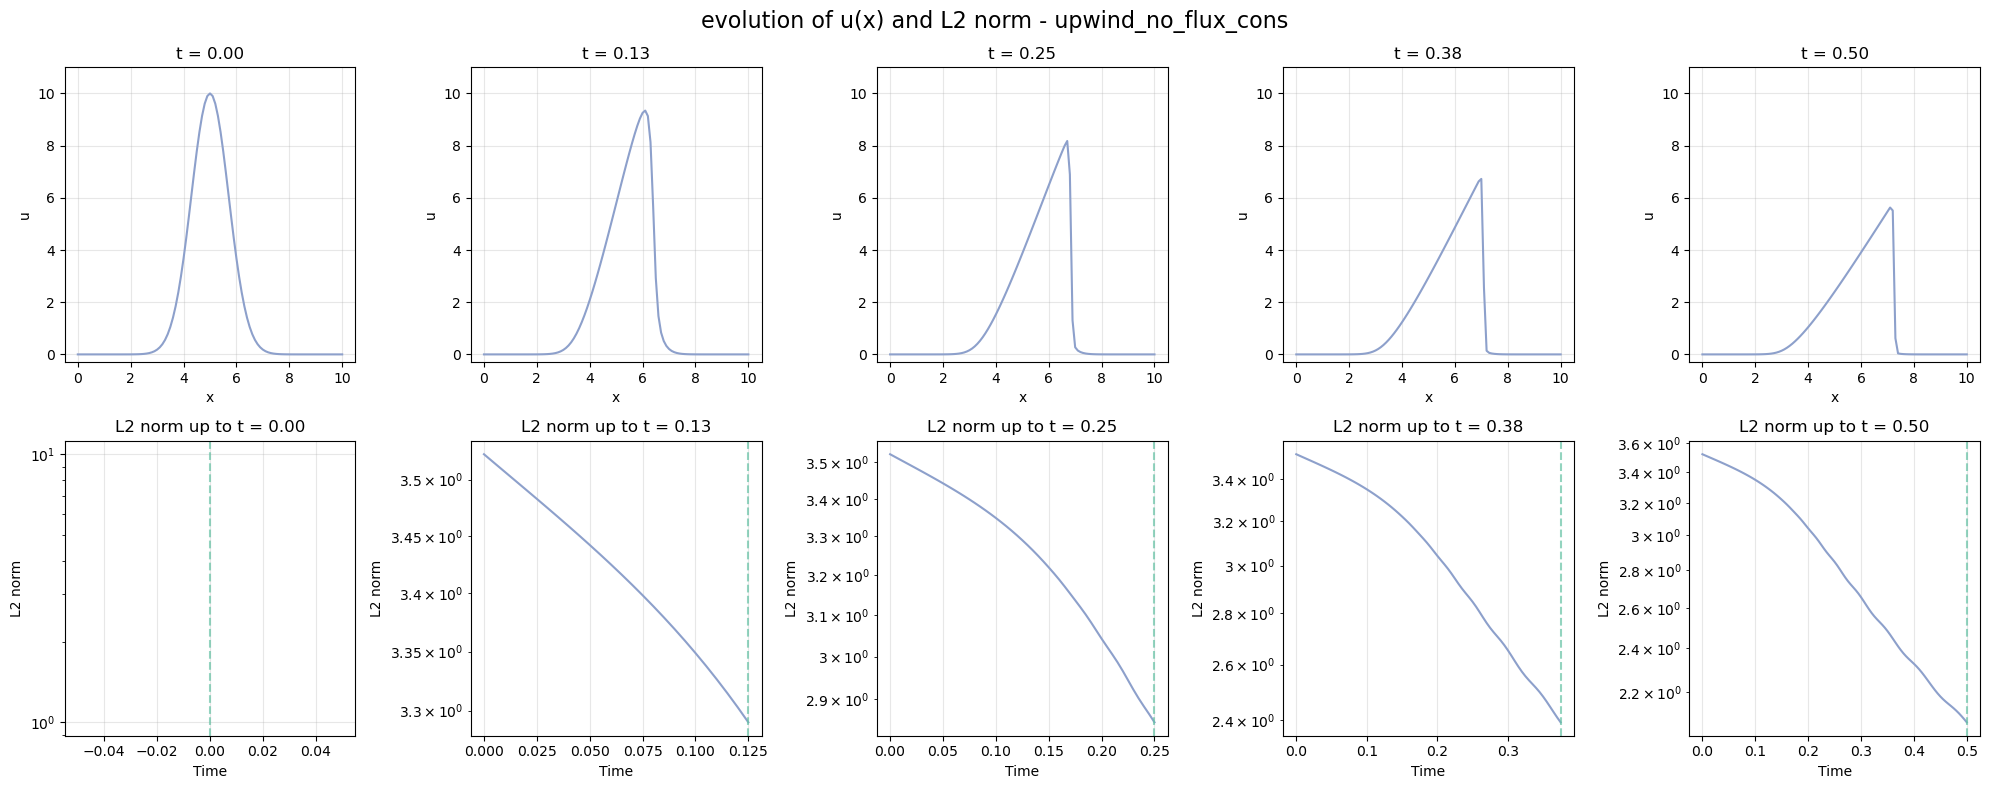

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Set2")

methods = ['upwind_flux_cons', 'upwind_no_flux_cons']
results = {}

params = {
    'L': 10.0,
    'nx': 101,
    'cf': 0.5,
    't_final': 0.5,
    'x0': 5,
    'u_initial': 'gaussian',
    'plots': True,
    'movie': False
}

for method in methods:
    print(f"Running {method}...")
    x, u_final, time, l2norm = burgers_equation(method=method, **params)
    results[method] = {
        'x': x,
        'u_final': u_final,
        'time': time,
        'l2norm': l2norm
    }


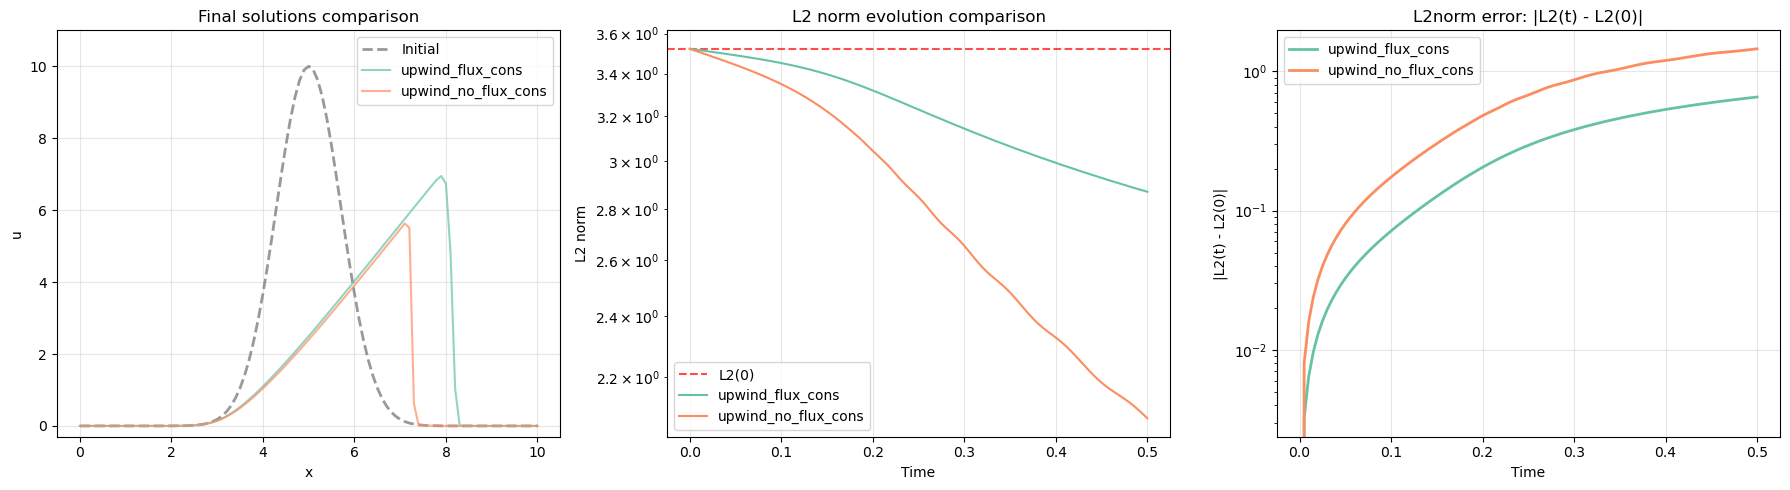


Final L2 norms:
upwind_flux_cons              : 2.869494e+00
upwind_no_flux_cons           : 2.073283e+00


In [156]:
u_in = 'gaussian'

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax1 = axes[0]
if u_in == 'step':
    u_initial = np.zeros_like(x)
    u_initial[(x >= 4) & (x <= 6)] = 1.0
elif u_in == 'gaussian':
    u_initial = 10 * np.exp(-((x - params['x0']) ** 2))
ax1.plot(x, u_initial, '--', color='grey', linewidth=2, label='Initial', alpha=0.8)
for i, method in enumerate(methods):
    ax1.plot(results[method]['x'], results[method]['u_final'], 
             color=colors[i], linewidth=1.5, alpha=0.7, label=method)
ax1.set_ylim(-0.3, 11)
ax1.set_xlabel('x')
ax1.set_ylabel('u')
ax1.set_title('Final solutions comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
initial_l2 = results[methods[0]]['l2norm'][0]  
ax2.axhline(y=initial_l2, color='red', linestyle='--', alpha=0.7, linewidth=1.5, label='L2(0)')
for i, method in enumerate(methods):
    ax2.plot(results[method]['time'], results[method]['l2norm'], 
             color=colors[i], linewidth=1.5, alpha=1, label=method)
ax2.set_xlabel('Time')
ax2.set_ylabel('L2 norm')
ax2.set_title('L2 norm evolution comparison')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[2]
for i, method in enumerate(methods):
    l2_initial = results[method]['l2norm'][0]
    l2_error = np.abs(np.array(results[method]['l2norm']) - l2_initial)
    ax3.plot(results[method]['time'], l2_error, 
             color=colors[i], linewidth=2, label=method)
ax3.set_xlabel('Time')
ax3.set_ylabel('|L2(t) - L2(0)|')
ax3.set_title('L2norm error: |L2(t) - L2(0)|')
ax3.set_yscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal L2 norms:")
for method in methods:
    final_l2 = results[method]['l2norm'][-1]
    print(f"{method:30}: {final_l2:.6e}")


In [161]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Set2")

def burgers_equation_parameter_comparisons(methods=['upwind_flux_conservative', 'upwind_non_flux_conservative'],
                                         cf_values=[0.1, 0.3, 0.5, 0.7],
                                         nx_values=[51, 101, 201, 401],
                                         L=10.0, t_final=0.5, x0=5, 
                                         u_initial='gaussian', fixed_param='cf', 
                                         fixed_value=0.5):

    if fixed_param == 'cf':
        vary_values = nx_values
        vary_label = 'nx'
        fixed_label = f'cf = {fixed_value}'
    else:
        vary_values = cf_values
        vary_label = 'cf'
        fixed_label = f'nx = {int(fixed_value)}'
    
    results = {}
    
    for method in methods:
        results[method] = {}
        
        for vary_val in vary_values:
            if fixed_param == 'cf':
                cf = fixed_value
                nx = int(vary_val)
            else:
                cf = vary_val
                nx = int(fixed_value)
            
            print(f"Running {method} with cf={cf}, nx={nx}")
            
            x, u_final, time, l2norm = burgers_equation(
                L=L, nx=nx, cf=cf, t_final=t_final, x0=x0,
                u_initial=u_initial, method=method, plots=False, 
                movie=False
            )
            
            results[method][vary_val] = {
                'x': x,
                'u_final': u_final,
                'time': time,
                'l2norm': l2norm,
                'cf': cf,
                'nx': nx
            }
    
    x_ref = np.linspace(0, 10, 101)
    if u_initial == 'gaussian':
        u_initial_ref = 10 * np.exp(-((x_ref - 5) ** 2))
    else:
        u_initial_ref = np.zeros_like(x_ref)
        u_initial_ref[(x_ref >= 4) & (x_ref <= 6)] = 1.0
    
    fig, axes = plt.subplots(len(methods), len(vary_values), 
                            figsize=(4*len(vary_values), 3*len(methods)))
    
    if len(methods) == 1:
        axes = axes.reshape(1, -1)
    if len(vary_values) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, method in enumerate(methods):
        for j, vary_val in enumerate(vary_values):
            ax = axes[i, j]
            data = results[method][vary_val]
            
            ax.plot(x_ref, u_initial_ref, '--', color='gray', alpha=0.7, 
                    label='initial', linewidth=1)
            ax.plot(data['x'], data['u_final'], color=colors[i], 
                    linewidth=2, label='final')
            
            ax.set_title(f'{method}, {vary_label} = {vary_val}')
            ax.set_ylim(-0.3, 11)
            ax.grid(True, alpha=0.3)
            
            if j == 0:
                ax.set_ylabel('u')
            if i == len(methods) - 1:
                ax.set_xlabel('x')
            if i == 0 and j == 0:
                ax.legend()
    
    plt.suptitle(f'Final solutions at t={t_final} ({fixed_label})', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(len(methods), 1, figsize=(10, 3*len(methods)))
    
    if len(methods) == 1:
        axes = [axes]
    
    for i, method in enumerate(methods):
        ax = axes[i]
        
        for j, vary_val in enumerate(vary_values):
            data = results[method][vary_val]
            
            ax.plot(data['time'], data['l2norm'], color=colors[j], 
                    linewidth=2, label=f'{vary_label} = {vary_val}')
        
        ax.axhline(y=results[method][vary_values[0]]['l2norm'][0], 
                color='firebrick', linestyle='--', alpha=0.7, linewidth=1.5, label='L2(0)')
        ax.set_yscale('log')
        ax.set_xlabel('Time')
        ax.set_ylabel('L2 norm')
        ax.set_title(f'{method} - L2 norm evolution')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'L2 norm evolution ({fixed_label})', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return results

Running upwind_flux_cons with cf=0.1, nx=101
Running upwind_flux_cons with cf=0.5, nx=101
Running upwind_flux_cons with cf=0.9, nx=101
Running upwind_flux_cons with cf=1.0, nx=101
Running upwind_flux_cons with cf=1.1, nx=101
Running upwind_no_flux_cons with cf=0.1, nx=101
Running upwind_no_flux_cons with cf=0.5, nx=101
Running upwind_no_flux_cons with cf=0.9, nx=101
Running upwind_no_flux_cons with cf=1.0, nx=101
Running upwind_no_flux_cons with cf=1.1, nx=101


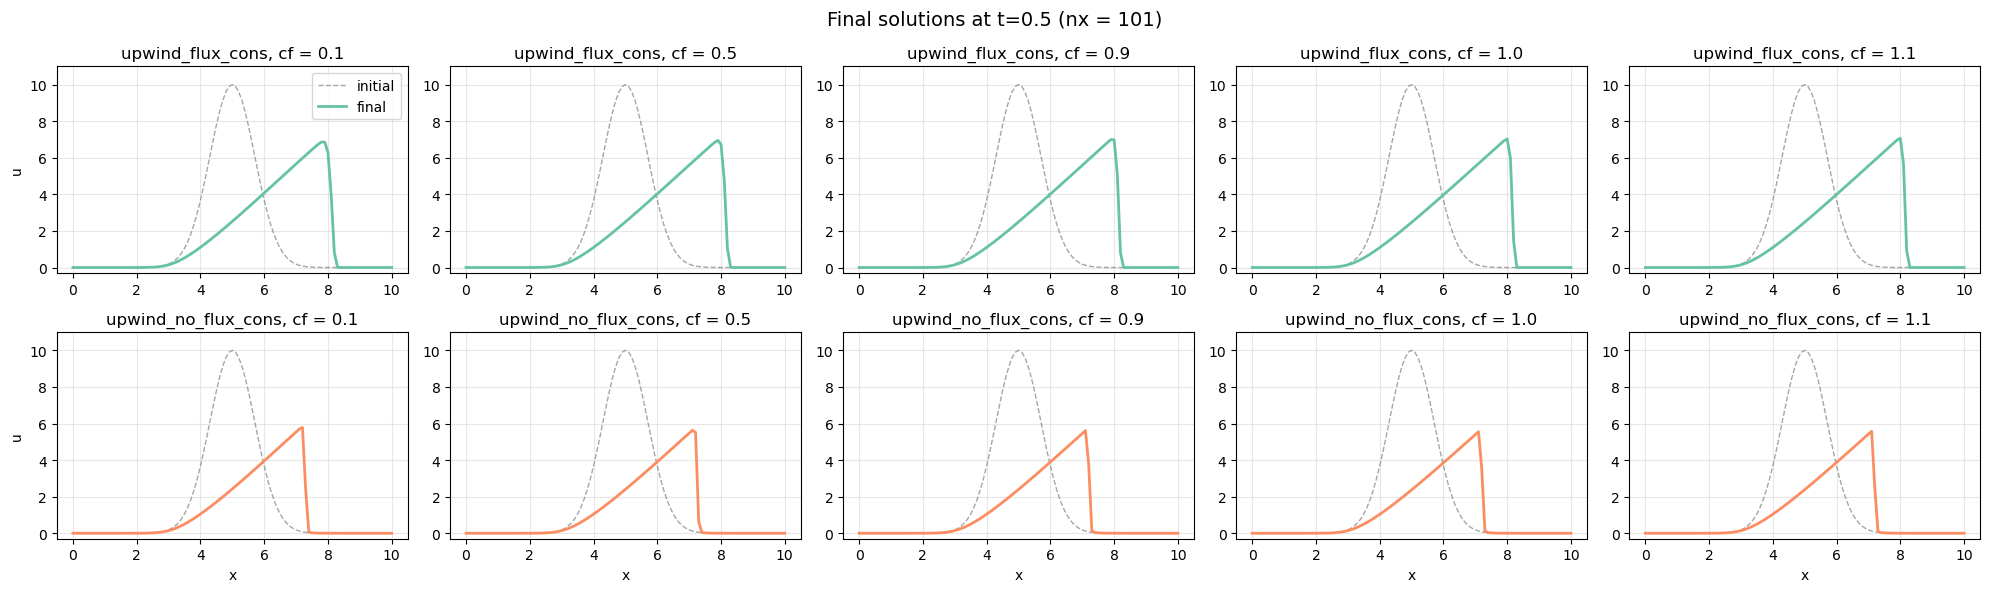

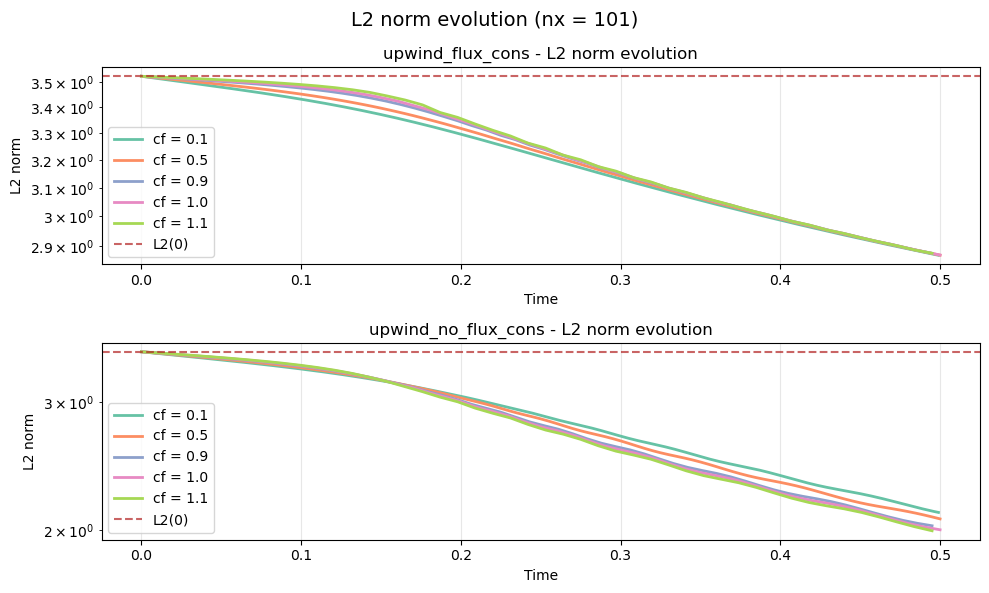

Running upwind_flux_cons with cf=0.5, nx=51
Running upwind_flux_cons with cf=0.5, nx=101
Running upwind_flux_cons with cf=0.5, nx=401
Running upwind_flux_cons with cf=0.5, nx=801
Running upwind_no_flux_cons with cf=0.5, nx=51
Running upwind_no_flux_cons with cf=0.5, nx=101
Running upwind_no_flux_cons with cf=0.5, nx=401
Running upwind_no_flux_cons with cf=0.5, nx=801


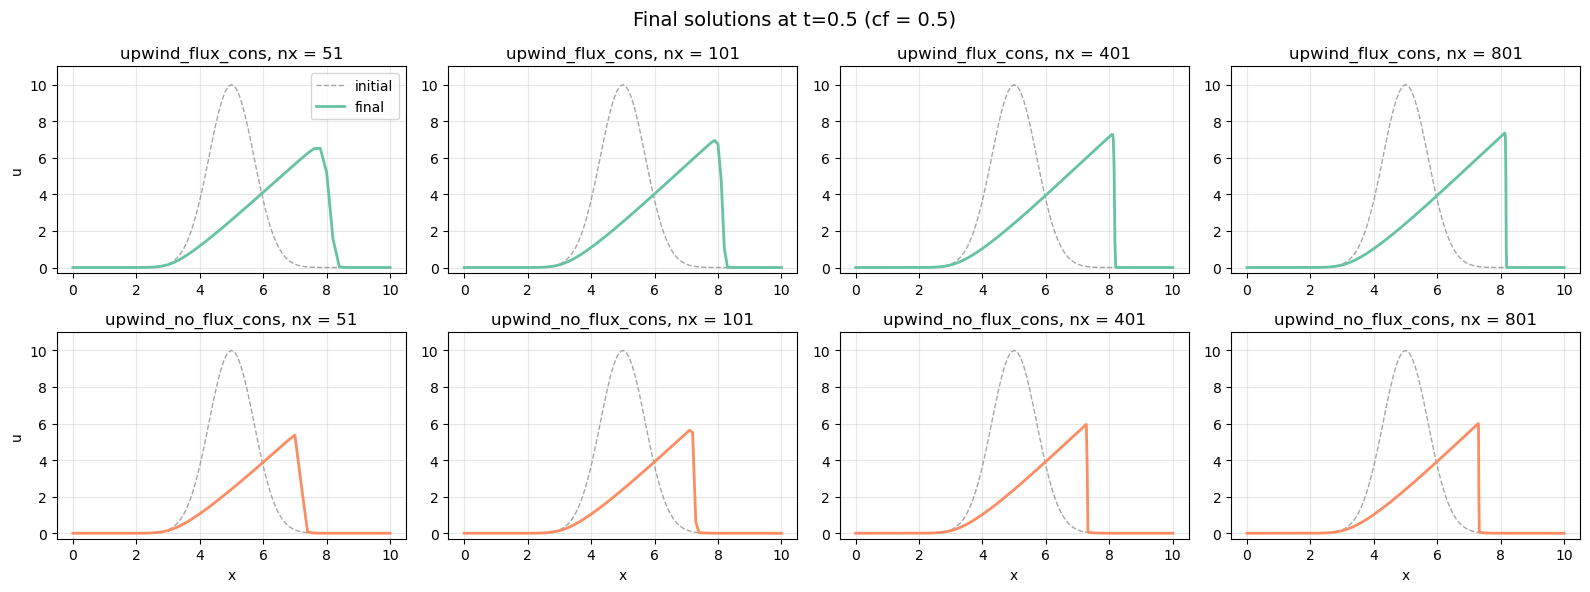

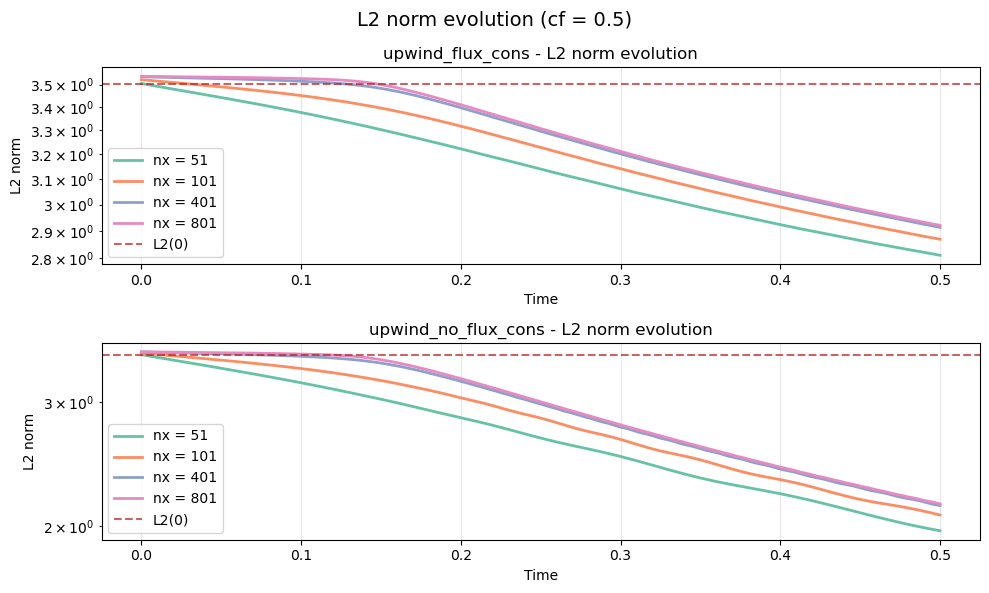

In [162]:
# different cf with fixed nx
results_cf = burgers_equation_parameter_comparisons(
    methods=['upwind_flux_cons', 'upwind_no_flux_cons'],
    cf_values=[0.1, 0.5, 0.9, 1.0, 1.1],
    fixed_param='nx',
    fixed_value=101,
    u_initial='gaussian'
)

# different nx with fixed cf
results_nx = burgers_equation_parameter_comparisons(
    methods=['upwind_flux_cons', 'upwind_no_flux_cons'],
    nx_values=[51, 101, 401, 801],
    fixed_param='cf',
    fixed_value=0.5,
    u_initial='gaussian'
)